In [28]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
# import skimage.io as io
import random
from torch_geometric.data import Data
os.chdir('/public/home/jijh/diffusion_project/ADiffusion')
import importlib
import src.preprocessing.data_process
importlib.reload(src.preprocessing.data_process)
from src.preprocessing.data_process import extract_patches, create_graph_data_dict, construct_affinity_matrix

In [29]:
def seed_everything(seed=0):
    """Initialize random seeds for reproducibility."""
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
# Set random seed for reproducibility
random_seed = 0
seed_everything(random_seed)

# Data Preparation

In [30]:

file_dir = "/public/home/jijh/st_project/cellbin_analysis/spatial_variation/wx_data/"  # Directory containing the data files
files = os.listdir(file_dir)  # List all files in the directory
files = [i for i in files if i.endswith(".h5ad") and "month" in i]  # Filter files to include only those ending with ".h5ad" and containing "month"
file_paths = [os.path.join(file_dir, i) for i in files]  # Create full file paths for the filtered files
adatas = {}  # Initialize an empty dictionary to store AnnData objects

# Read each file and store the AnnData object in the dictionary
for i in range(len(file_paths)):
    adatas[files[i].split(".")[0]] = sc.read(file_paths[i])

In [31]:
# Preprocess each AnnData object
for key in tqdm(adatas.keys(), desc="Preprocessing datasets"):
    sc.pp.normalize_total(adatas[key], target_sum=1e4)  # Normalize counts per cell
    sc.pp.log1p(adatas[key])  # Logarithmize the data
    adatas[key].layers["raw"] = adatas[key].X.copy()  # Store the raw data in the "raw" layer
    sc.pp.scale(adatas[key], max_value=10)  # Scale the data to have a maximum value of 10
    sc.tl.pca(adatas[key], svd_solver="arpack")  # Perform PCA

Preprocessing datasets: 100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


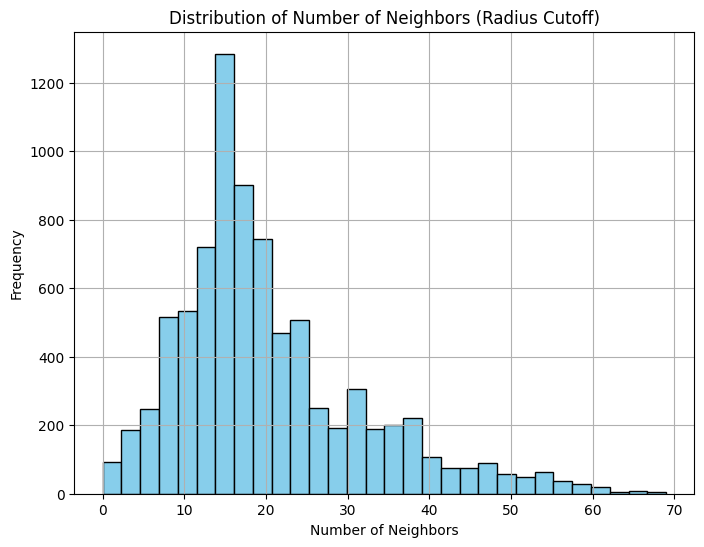

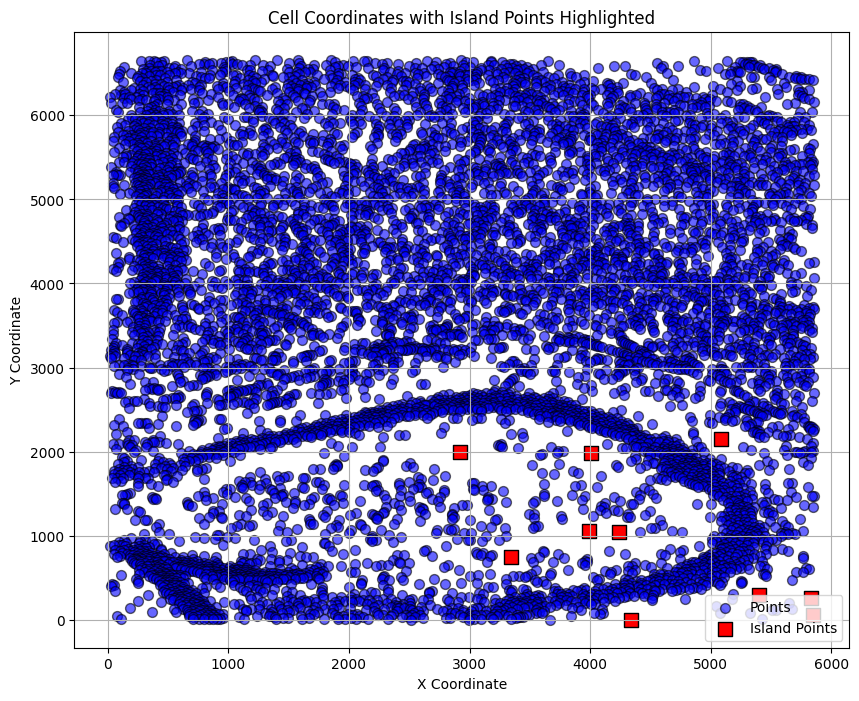

Number of island points: 10
Island point indices: [6068 6224 6239 6894 6901 7122 7792 7836 8110 8179]


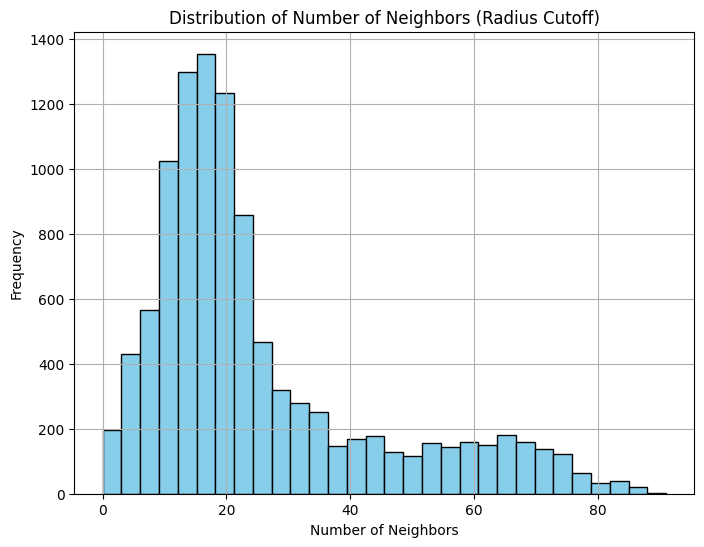

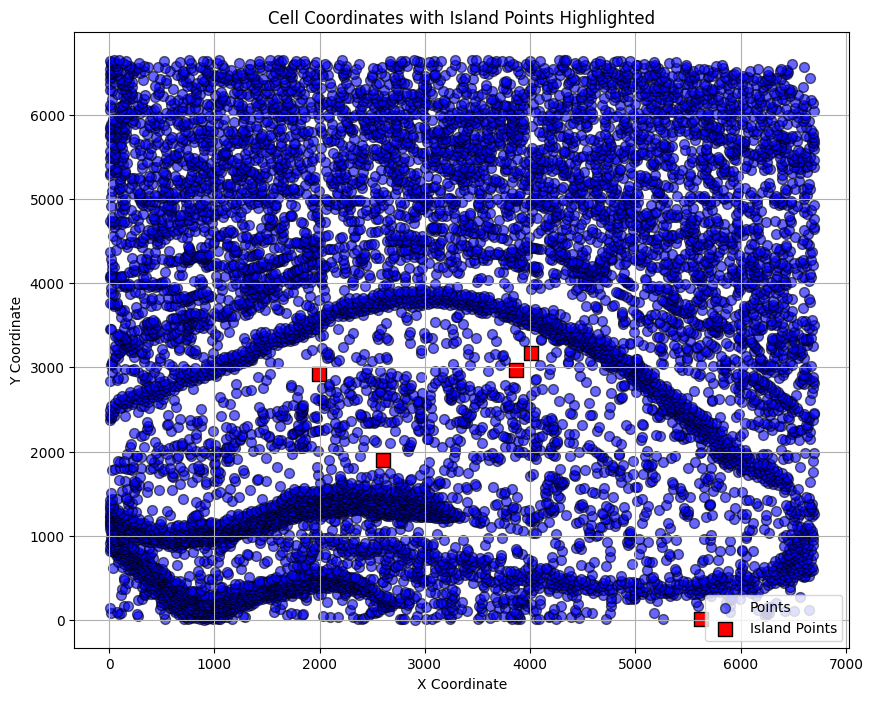

Number of island points: 5
Island point indices: [  10 3425 4504 4549 4785]


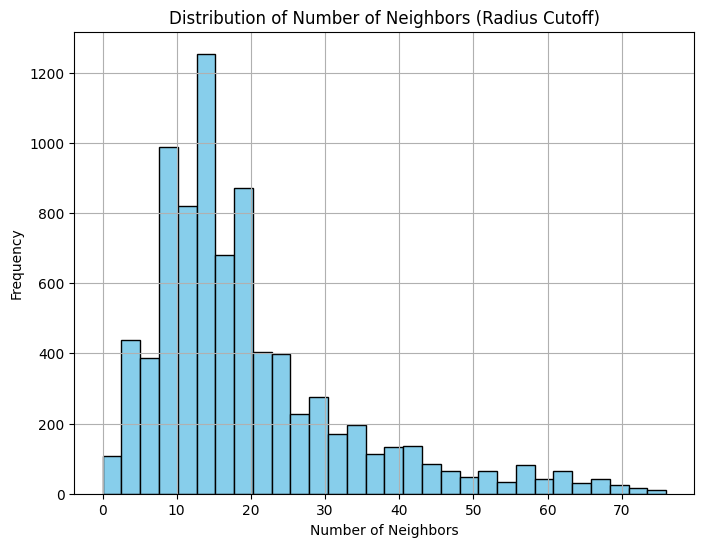

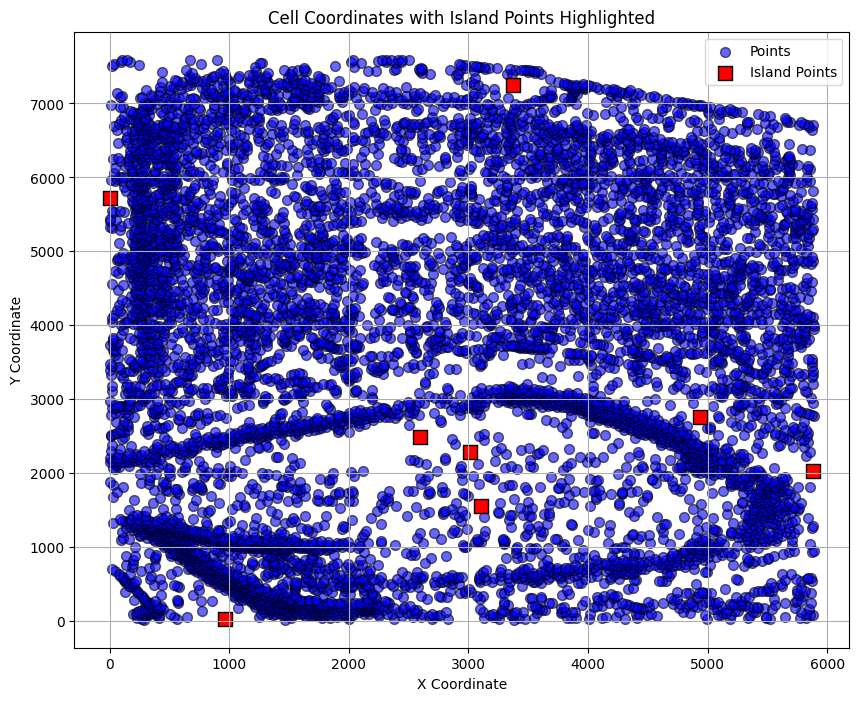

Number of island points: 8
Island point indices: [  18 1924 2222 2409 2557 2862 6377 8043]


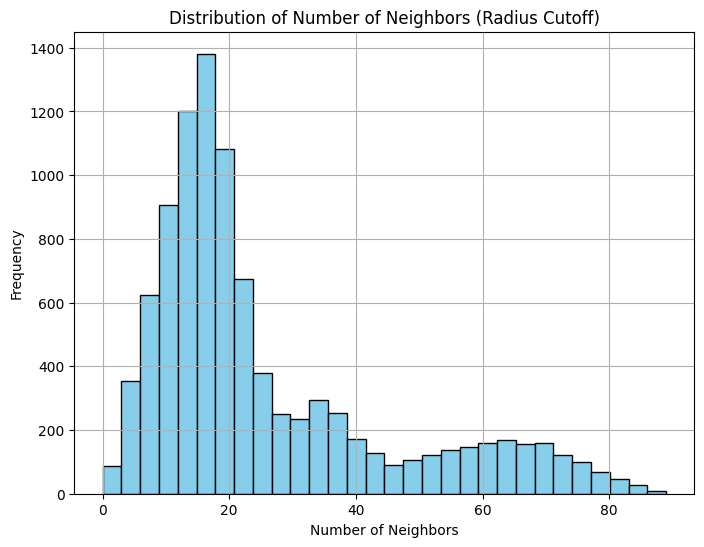

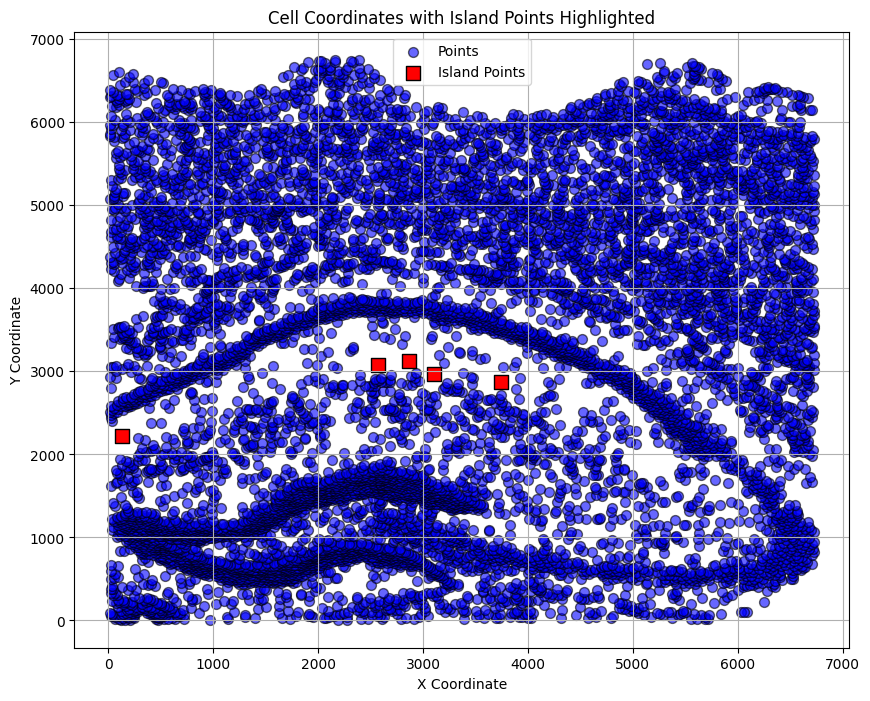

Number of island points: 5
Island point indices: [3815 4489 4600 4719 4759]


In [32]:
# Extract spatial coordinates for each cell
cell_coords = {}
for key in adatas.keys():
    cell_coords[key] = adatas[key].obsm["spatial"].copy()
neighbors = {}
for key in cell_coords.keys():
    neighbors[key] = construct_affinity_matrix(cell_coords[key], mode="radius", cutoff=150, add_self_loop=True)

In [33]:
from skimage import io

# Load the plaque dataset
img_dir = "/public/home/jijh/st_project/cellbin_analysis/spatial_variation/wx_data/protein_seg_result/"
img_files = os.listdir(img_dir)
img_files = [i for i in img_files if i.endswith(".tiff") and "plaque" in i]
# Read the images

imgs = {}
for i in range(len(img_files)):
    imgs[img_files[i].split(".")[0]] = io.imread(os.path.join(img_dir, img_files[i]))
imgs.keys()
# Rename the imgs to match the adata keys
for key in list(imgs.keys()):
    parts = key.split("_")
    if len(parts) > 1:
        new_key = parts[1] + "_" + parts[2]
        imgs[new_key] = imgs.pop(key)


# Extract patches from the images
patches = {}
for key in imgs.keys():
    patches[key] = extract_patches(imgs[key], cell_coords[key], patch_size=128)

# Convert the patches to binary and calculate the area of positive pixels for each patch
binary_patches = {}
for key in patches.keys():
    binary_patches[key] = [patch > 0 for patch in patches[key]]
# Calculate the area of positive pixels for each patch
areas = {}
for key in binary_patches.keys():
    areas[key] = [np.sum(patch) for patch in binary_patches[key]]

Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0


In [34]:
# Create the graph dictionary
graph_data_dict = create_graph_data_dict(adatas=adatas, neighbors=neighbors, cell_coords=cell_coords, embeddings="X", areas=areas)

Creating graph data: 100%|██████████| 4/4 [00:00<00:00, 22.75it/s]


In [9]:
graph_data_dict

{'8months-disease-replicate_1': Data(x=[8186, 2766], edge_index=[2, 174496], edge_attr=[174496, 1], y=[8186, 1], pos=[8186, 2]),
 '13months-disease-replicate_1': Data(x=[10372, 2766], edge_index=[2, 274350], edge_attr=[274350, 1], y=[10372, 1], pos=[10372, 2]),
 '8months-disease-replicate_2': Data(x=[8202, 2766], edge_index=[2, 169480], edge_attr=[169480, 1], y=[8202, 1], pos=[8202, 2]),
 '13months-disease-replicate_2': Data(x=[9634, 2766], edge_index=[2, 255516], edge_attr=[255516, 1], y=[9634, 1], pos=[9634, 2])}

# My personal STAGATE

In [9]:
from torch_geometric.nn import GATConv
import torch.nn.functional as F

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt

class STAGATE_GAE(nn.Module):
    def __init__(
            self,
            in_channels: int,
            heads_per_layer: list = [1, 1],
            hidden_channels: list = [256, 256],
            dropout: float = 0.0,
            edge_dropout: float = 0.0,
    ):
        super(STAGATE_GAE, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.heads_per_layer = heads_per_layer
        self.dropout = dropout
        self.edge_dropout = edge_dropout
        self.num_layers = len(hidden_channels)

        self.encoder_convs = nn.ModuleList()
        self.decoder_convs = nn.ModuleList()

        # Encoder
        for i in range(self.num_layers):
            conv_in_channels = in_channels if i == 0 else hidden_channels[i - 1]
            conv_out_channels = hidden_channels[i]
            heads = heads_per_layer[i]
            gat_conv = GATConv(
                conv_in_channels,
                conv_out_channels,
                heads=heads,
                dropout=dropout,
                add_self_loops=True,
                concat=False
            )
            self.encoder_convs.append(gat_conv)

        # Decoder (Symmetric to the encoder)
        for i in range(self.num_layers - 1, -1, -1):
            # 使用上一层 decoder 的输出维度作为输入，例如：
            conv_in_channels = hidden_channels[i]  # 或根据多头机制加权
            conv_out_channels = in_channels if i == 0 else hidden_channels[i - 1]
            heads = heads_per_layer[i]
            gat_conv = GATConv(
                conv_in_channels,
                conv_out_channels,
                heads=heads,
                dropout=dropout,
                add_self_loops=True,
                concat=False
            )
            self.decoder_convs.append(gat_conv)

        # Initialize weights using Xavier initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """
        Initialize weights of GATConv layers using Xavier (Glorot) initialization.
        """
        if isinstance(module, GATConv):
            # 对于 lin_src，确保其不为 None 再进行初始化
            if hasattr(module, 'lin_src') and module.lin_src is not None:
                if module.lin_src.weight is not None:
                    nn.init.xavier_uniform_(module.lin_src.weight)
                if module.lin_src.bias is not None:
                    nn.init.zeros_(module.lin_src.bias)

            # 对于 lin_dst，同样先进行 None 检查
            if hasattr(module, 'lin_dst') and module.lin_dst is not None:
                if module.lin_dst.weight is not None:
                    nn.init.xavier_uniform_(module.lin_dst.weight)
                if module.lin_dst.bias is not None:
                    nn.init.zeros_(module.lin_dst.bias)
                
            # Attention 权重初始化
            if hasattr(module, 'att') and module.att is not None:
                nn.init.xavier_uniform_(module.att)

    def forward(self, data: Data, return_hidden=False):
        """
        Forward pass through the encoder and decoder.

        Parameters:
        - data: PyTorch Geometric Data object containing `x` and `edge_index`.
        - return_hidden: If True, returns hidden representations from all layers.

        Returns:
        - Reconstructed node embeddings or a tuple of (reconstructed embeddings, hidden layers).
        """
        x, edge_index = data.x, data.edge_index

        hiddens_per_layer = []

        # Encoder
        for i in range(self.num_layers):
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.encoder_convs[i](x, edge_index)
            x = F.elu(x)
            hiddens_per_layer.append(x)

        # Decoder
        for i in range(self.num_layers):
            x = F.dropout(x, p=self.dropout, training=self.training)
            # Assuming symmetric architecture; adjust if different
            # Concatenate with the corresponding encoder layer output if needed
            # Here, it's simplified
            x = self.decoder_convs[i](x, edge_index)
            x = F.elu(x)
            hiddens_per_layer.append(x)

        if return_hidden:
            return x, hiddens_per_layer
        else:
            return x


In [16]:

data = graph_data_dict['13months-disease-replicate_1'].clone()
# Test for a single forward pass
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

in_channels = data.x.size(-1)

model = STAGATE_GAE(in_channels=in_channels, hidden_channels=[512, 30], heads_per_layer=[1, 1], dropout=0.0).to(device)
data = data.to(device)

model(data)


tensor([[ 0.0089, -0.0613, -0.0294,  ..., -0.0050,  0.0328, -0.0129],
        [-0.0336,  0.0824,  0.0254,  ..., -0.1263, -0.0201, -0.0752],
        [ 0.0134,  0.0660,  0.0264,  ...,  0.0303, -0.0517,  0.0767],
        ...,
        [-0.0252,  0.0699, -0.1030,  ...,  0.0221,  0.1333, -0.0346],
        [ 0.0846,  0.0135, -0.0728,  ...,  0.0157,  0.0170, -0.0671],
        [-0.0249,  0.0723, -0.1014,  ...,  0.0209,  0.1345, -0.0361]],
       device='cuda:0', grad_fn=<EluBackward0>)

In [22]:
# -------------------------------
# 训练过程定义：train_STAGATE_GAE
# -------------------------------
import numpy as np
import random
from tqdm import tqdm
import torch.backends.cudnn as cudnn
cudnn.deterministic = True
cudnn.benchmark = True

def train_STAGATE_GAE(graph_data: Data,
                      hidden_channels=[512, 30],
                      n_epochs=1000,
                      lr=0.001,
                      weight_decay=0.0001,
                      gradient_clipping=5.0,
                      random_seed=0,
                      verbose=True,
                      device=None):
    """
    训练图注意力自编码器（STAGATE_GAE）。

    参数:
    - graph_data: torch_geometric.data.Data 对象，包含节点特征 x 和边索引 edge_index。
    - hidden_channels: 编码器各层的输出维度列表。
    - n_epochs: 总训练轮数。
    - lr: 学习率。
    - weight_decay: 权重衰减。
    - gradient_clipping: 梯度裁剪阈值。
    - random_seed: 随机种子。
    - verbose: 是否打印训练过程中日志信息。
    - device: 设备，如果为 None，则自动选择 GPU (若可用) 或 CPU。

    返回:
    - model: 训练后的模型
    - latent_rep: 节点的低维潜在表示（取自 encoder 最后一层的输出）
    - loss_list: 各轮训练损失列表
    """
    if device is None:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # 设置随机种子
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_seed)

    # 将数据移动到设备上
    graph_data = graph_data.to(device)

    # 模型初始化：in_channels 为节点特征维度
    in_channels = graph_data.x.size(-1)
    # 注意：heads_per_layer 这里设为全 1，使得每层输出维度不改变（因 concat=False）
    model = STAGATE_GAE(in_channels=in_channels,
                        hidden_channels=hidden_channels,
                        heads_per_layer=[1] * len(hidden_channels),
                        dropout=0.0).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_list = []

    model.train()
    for epoch in tqdm(range(1, n_epochs + 1), desc="Training"):
        optimizer.zero_grad()
        # 前向传播，获得重构后的节点特征
        out = model(graph_data)
        # 使用均方误差损失重构原始节点特征
        loss = F.mse_loss(out, graph_data.x)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
        optimizer.step()

        loss_list.append(loss.item())
        if verbose and epoch % 100 == 0:
            print(f"Epoch: {epoch:4d}, Loss: {loss.item():.4f}")

    # 训练结束后提取潜在表示
    model.eval()
    with torch.no_grad():
        # 此处采用 forward(return_hidden=True) 得到所有层的隐藏表示，
        # 我们选取 encoder 部分最后一层的输出作为节点的潜在表示
        _, hiddens = model(graph_data, return_hidden=True)
        # encoder 隐藏表示位于 hiddens[0] ~ hiddens[model.num_layers-1]
        latent_rep = hiddens[model.num_layers - 1]
    
    latent_rep_np = latent_rep.cpu().numpy()

    return model, latent_rep_np, loss_list

Training:   5%|▌         | 102/2000 [00:05<01:43, 18.27it/s]

Epoch:  100, Loss: 0.9538


Training:  10%|█         | 202/2000 [00:11<01:38, 18.28it/s]

Epoch:  200, Loss: 0.9518


Training:  15%|█▌        | 302/2000 [00:16<01:32, 18.30it/s]

Epoch:  300, Loss: 0.9481


Training:  20%|██        | 402/2000 [00:21<01:27, 18.29it/s]

Epoch:  400, Loss: 0.9415


Training:  25%|██▌       | 502/2000 [00:27<01:22, 18.19it/s]

Epoch:  500, Loss: 0.9356


Training:  30%|███       | 602/2000 [00:32<01:16, 18.20it/s]

Epoch:  600, Loss: 0.9280


Training:  35%|███▌      | 702/2000 [00:38<01:11, 18.24it/s]

Epoch:  700, Loss: 0.9257


Training:  40%|████      | 802/2000 [00:43<01:06, 18.14it/s]

Epoch:  800, Loss: 0.9215


Training:  45%|████▌     | 902/2000 [00:49<01:00, 18.08it/s]

Epoch:  900, Loss: 0.9184


Training:  50%|█████     | 1002/2000 [00:55<00:55, 17.93it/s]

Epoch: 1000, Loss: 0.9175


Training:  55%|█████▌    | 1102/2000 [01:00<00:49, 18.09it/s]

Epoch: 1100, Loss: 0.9156


Training:  60%|██████    | 1202/2000 [01:06<00:44, 18.10it/s]

Epoch: 1200, Loss: 0.9173


Training:  65%|██████▌   | 1302/2000 [01:11<00:38, 18.11it/s]

Epoch: 1300, Loss: 0.9147


Training:  70%|███████   | 1402/2000 [01:17<00:33, 17.92it/s]

Epoch: 1400, Loss: 0.9194


Training:  75%|███████▌  | 1502/2000 [01:22<00:27, 18.07it/s]

Epoch: 1500, Loss: 0.9137


Training:  80%|████████  | 1602/2000 [01:28<00:22, 17.90it/s]

Epoch: 1600, Loss: 0.9129


Training:  85%|████████▌ | 1702/2000 [01:33<00:16, 18.13it/s]

Epoch: 1700, Loss: 0.9189


Training:  90%|█████████ | 1802/2000 [01:39<00:10, 18.13it/s]

Epoch: 1800, Loss: 0.9126


Training:  95%|█████████▌| 1902/2000 [01:44<00:05, 18.11it/s]

Epoch: 1900, Loss: 0.9116


Training: 100%|██████████| 2000/2000 [01:50<00:00, 18.14it/s]


Epoch: 2000, Loss: 0.9117


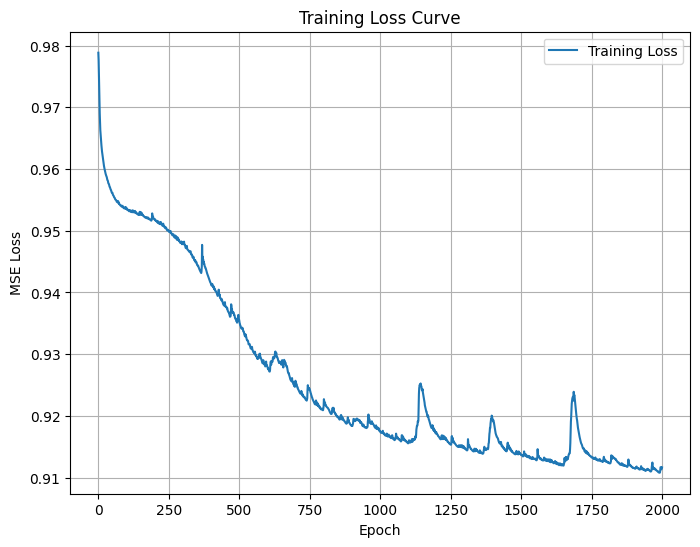

Latent representation shape: (10372, 30)


In [20]:
# 调用训练过程，hidden_channels 设为 [512, 30]
model, latent_rep, loss_list = train_STAGATE_GAE(
        data,
        hidden_channels=[512, 30],
        n_epochs=2000,  # 可根据需求增加训练轮数
        lr=0.001,
        weight_decay=0.0001,
        gradient_clipping=5.0,
        random_seed=42,
        verbose=True,
        device=device
    )

# 绘制损失曲线
plt.figure(figsize=(8, 6))
plt.plot(loss_list, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# latent_rep 即为节点的低维表示，可供后续聚类或可视化使用
print("Latent representation shape:", latent_rep.shape)

In [23]:
adata = adatas['13months-disease-replicate_1'].copy()
adata.obsm['X_STAGATE'] = latent_rep
sc.pp.neighbors(adata, use_rep="X_STAGATE", n_neighbors=30)
sc.tl.leiden(adata, key_added="leiden_STAGATE", resolution=0.1)

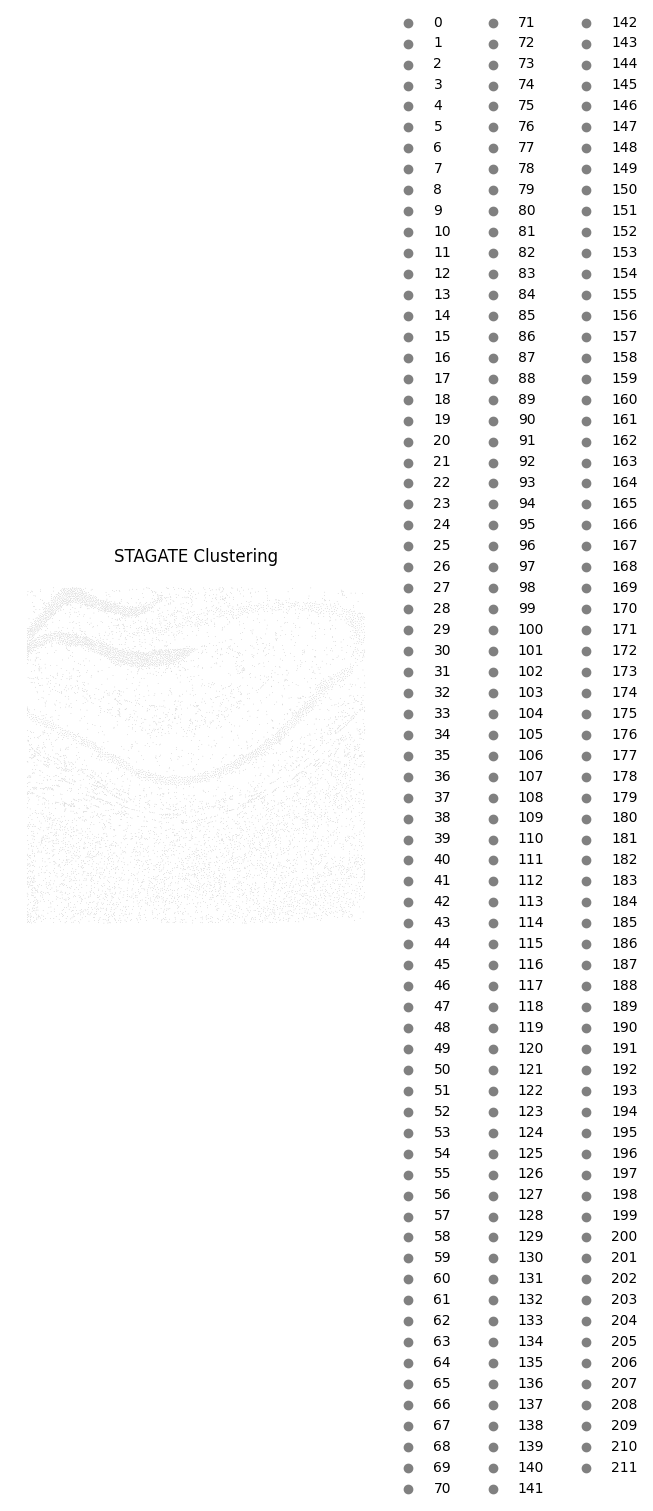

In [24]:
sc.pl.spatial(adata, color="leiden_STAGATE", spot_size=10, title="STAGATE Clustering", ncols=3, frameon=False)

# 用它的数据构建方式

In [7]:
import sklearn.neighbors
import scipy.sparse as sp

def Cal_Spatial_Net(adata, rad_cutoff=None, k_cutoff=None, model='Radius', verbose=True):
    """\
    Construct the spatial neighbor networks.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    rad_cutoff
        radius cutoff when model='Radius'
    k_cutoff
        The number of nearest neighbors when model='KNN'
    model
        The network construction model. When model=='Radius', the spot is connected to spots whose distance is less than rad_cutoff. When model=='KNN', the spot is connected to its first k_cutoff nearest neighbors.
    
    Returns
    -------
    The spatial networks are saved in adata.uns['Spatial_Net']
    """

    assert(model in ['Radius', 'KNN'])
    if verbose:
        print('------Calculating spatial graph...')
    coor = pd.DataFrame(adata.obsm['spatial'])
    coor.index = adata.obs.index
    coor.columns = ['imagerow', 'imagecol']

    if model == 'Radius':
        nbrs = sklearn.neighbors.NearestNeighbors(radius=rad_cutoff).fit(coor)
        distances, indices = nbrs.radius_neighbors(coor, return_distance=True)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices[it].shape[0], indices[it], distances[it])))
    
    if model == 'KNN':
        nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k_cutoff+1).fit(coor)
        distances, indices = nbrs.kneighbors(coor)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices.shape[1],indices[it,:], distances[it,:])))

    KNN_df = pd.concat(KNN_list)
    KNN_df.columns = ['Cell1', 'Cell2', 'Distance']

    Spatial_Net = KNN_df.copy()
    Spatial_Net = Spatial_Net.loc[Spatial_Net['Distance']>0,]
    id_cell_trans = dict(zip(range(coor.shape[0]), np.array(coor.index), ))
    Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
    Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
    if verbose:
        print('The graph contains %d edges, %d cells.' %(Spatial_Net.shape[0], adata.n_obs))
        print('%.4f neighbors per cell on average.' %(Spatial_Net.shape[0]/adata.n_obs))

    adata.uns['Spatial_Net'] = Spatial_Net

In [8]:
def Transfer_pytorch_Data(adata):
    G_df = adata.uns['Spatial_Net'].copy()
    cells = np.array(adata.obs_names)
    cells_id_tran = dict(zip(cells, range(cells.shape[0])))
    G_df['Cell1'] = G_df['Cell1'].map(cells_id_tran)
    G_df['Cell2'] = G_df['Cell2'].map(cells_id_tran)

    G = sp.coo_matrix((np.ones(G_df.shape[0]), (G_df['Cell1'], G_df['Cell2'])), shape=(adata.n_obs, adata.n_obs))
    G = G + sp.eye(G.shape[0])

    edgeList = np.nonzero(G)
    if type(adata.X) == np.ndarray:
        data = Data(edge_index=torch.LongTensor(np.array(
            [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X))  # .todense()
    else:
        data = Data(edge_index=torch.LongTensor(np.array(
            [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X.todense()))  # .todense()
    return data

def Batch_Data(adata, num_batch_x, num_batch_y, spatial_key=['X', 'Y'], plot_Stats=False):
    Sp_df = adata.obs.loc[:, spatial_key].copy()
    Sp_df = np.array(Sp_df)
    batch_x_coor = [np.percentile(Sp_df[:, 0], (1/num_batch_x)*x*100) for x in range(num_batch_x+1)]
    batch_y_coor = [np.percentile(Sp_df[:, 1], (1/num_batch_y)*x*100) for x in range(num_batch_y+1)]

    Batch_list = []
    for it_x in range(num_batch_x):
        for it_y in range(num_batch_y):
            min_x = batch_x_coor[it_x]
            max_x = batch_x_coor[it_x+1]
            min_y = batch_y_coor[it_y]
            max_y = batch_y_coor[it_y+1]
            temp_adata = adata.copy()
            temp_adata = temp_adata[temp_adata.obs[spatial_key[0]].map(lambda x: min_x <= x <= max_x)]
            temp_adata = temp_adata[temp_adata.obs[spatial_key[1]].map(lambda y: min_y <= y <= max_y)]
            Batch_list.append(temp_adata)
    if plot_Stats:
        f, ax = plt.subplots(figsize=(1, 3))
        plot_df = pd.DataFrame([x.shape[0] for x in Batch_list], columns=['#spot/batch'])
        sns.boxplot(y='#spot/batch', data=plot_df, ax=ax)
        sns.stripplot(y='#spot/batch', data=plot_df, ax=ax, color='red', size=5)
    return Batch_list

In [9]:
adata = adatas['13months-disease-replicate_1'].copy()
Cal_Spatial_Net(adata, rad_cutoff=150, model='Radius', verbose=True)

------Calculating spatial graph...
The graph contains 263978 edges, 10372 cells.
25.4510 neighbors per cell on average.


In [10]:
data = Transfer_pytorch_Data(adata)

In [36]:
data

Data(x=[10372, 2766], edge_index=[2, 274350])

Training:   5%|▌         | 102/2000 [00:05<01:43, 18.28it/s]

Epoch:  100, Loss: 0.9535


Training:  10%|█         | 202/2000 [00:11<01:38, 18.27it/s]

Epoch:  200, Loss: 0.9514


Training:  15%|█▌        | 302/2000 [00:16<01:32, 18.27it/s]

Epoch:  300, Loss: 0.9477


Training:  20%|██        | 402/2000 [00:22<01:27, 18.25it/s]

Epoch:  400, Loss: 0.9415


Training:  25%|██▌       | 502/2000 [00:27<01:22, 18.24it/s]

Epoch:  500, Loss: 0.9342


Training:  30%|███       | 602/2000 [00:32<01:16, 18.27it/s]

Epoch:  600, Loss: 0.9294


Training:  35%|███▌      | 702/2000 [00:38<01:11, 18.22it/s]

Epoch:  700, Loss: 0.9230


Training:  40%|████      | 802/2000 [00:43<01:05, 18.26it/s]

Epoch:  800, Loss: 0.9207


Training:  45%|████▌     | 902/2000 [00:49<01:00, 18.20it/s]

Epoch:  900, Loss: 0.9201


Training:  50%|█████     | 1002/2000 [00:54<00:54, 18.22it/s]

Epoch: 1000, Loss: 0.9169


Training:  55%|█████▌    | 1102/2000 [01:00<00:49, 18.22it/s]

Epoch: 1100, Loss: 0.9154


Training:  60%|██████    | 1202/2000 [01:05<00:43, 18.23it/s]

Epoch: 1200, Loss: 0.9163


Training:  65%|██████▌   | 1302/2000 [01:11<00:38, 18.21it/s]

Epoch: 1300, Loss: 0.9136


Training:  70%|███████   | 1402/2000 [01:16<00:32, 18.22it/s]

Epoch: 1400, Loss: 0.9141


Training:  75%|███████▌  | 1502/2000 [01:22<00:27, 18.24it/s]

Epoch: 1500, Loss: 0.9130


Training:  80%|████████  | 1602/2000 [01:27<00:21, 18.26it/s]

Epoch: 1600, Loss: 0.9123


Training:  85%|████████▌ | 1702/2000 [01:33<00:16, 18.21it/s]

Epoch: 1700, Loss: 0.9109


Training:  90%|█████████ | 1802/2000 [01:38<00:10, 18.21it/s]

Epoch: 1800, Loss: 0.9165


Training:  95%|█████████▌| 1902/2000 [01:44<00:05, 18.19it/s]

Epoch: 1900, Loss: 0.9106


Training: 100%|██████████| 2000/2000 [01:49<00:00, 18.23it/s]


Epoch: 2000, Loss: 0.9096


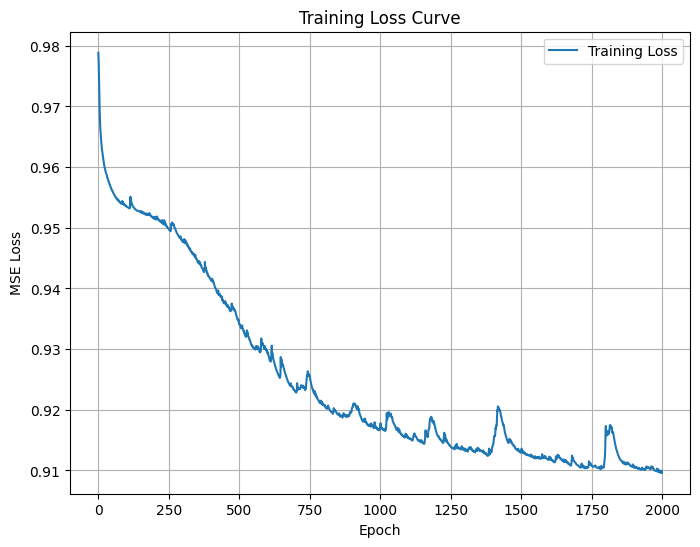

Latent representation shape: (10372, 30)


In [37]:
# 调用训练过程，hidden_channels 设为 [512, 30]
model, latent_rep, loss_list = train_STAGATE_GAE(
        data,
        hidden_channels=[512, 30],
        n_epochs=2000,  # 可根据需求增加训练轮数
        lr=0.001,
        weight_decay=0.0001,
        gradient_clipping=5.0,
        random_seed=42,
        verbose=True,
        device=device
    )

# 绘制损失曲线
plt.figure(figsize=(8, 6))
plt.plot(loss_list, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# latent_rep 即为节点的低维表示，可供后续聚类或可视化使用
print("Latent representation shape:", latent_rep.shape)

In [38]:
adata.obsm['X_STAGATE'] = latent_rep
sc.pp.neighbors(adata, use_rep="X_STAGATE", n_neighbors=30)
sc.tl.leiden(adata, key_added="leiden_STAGATE", resolution=0.1)

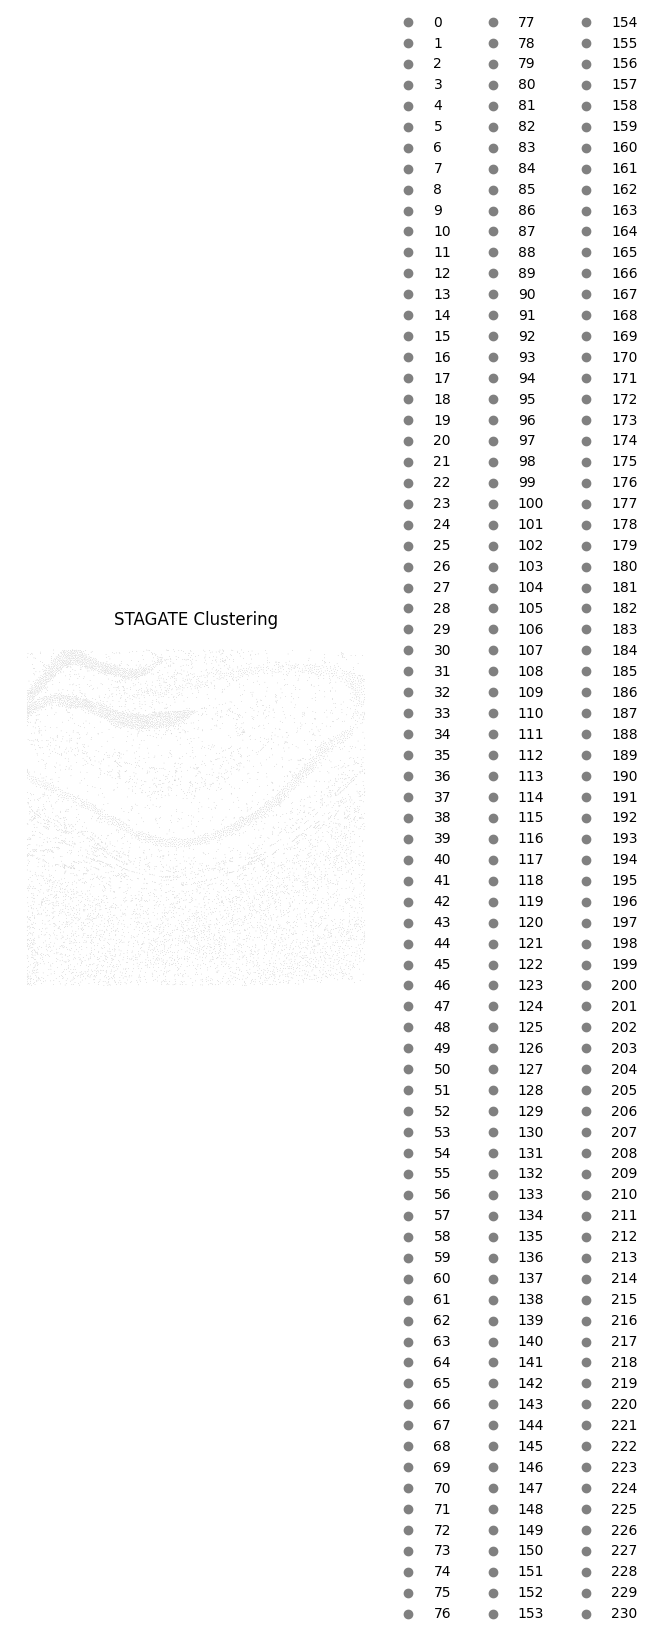

In [39]:
sc.pl.spatial(adata, color="leiden_STAGATE", spot_size=10, title="STAGATE Clustering", ncols=3, frameon=False)

# 我的数据搭建，它的模型

In [10]:
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter
import torch.nn as nn
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax



class STAGATEconv(MessagePassing):
    r"""The graph attentional operator from the `"Graph Attention Networks"
    <https://arxiv.org/abs/1710.10903>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \alpha_{i,i}\mathbf{\Theta}\mathbf{x}_{i} +
        \sum_{j \in \mathcal{N}(i)} \alpha_{i,j}\mathbf{\Theta}\mathbf{x}_{j},

    where the attention coefficients :math:`\alpha_{i,j}` are computed as

    .. math::
        \alpha_{i,j} =
        \frac{
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_j]
        \right)\right)}
        {\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_k]
        \right)\right)}.

    Args:
        in_channels (int or tuple): Size of each input sample, or :obj:`-1` to
            derive the size from the first input(s) to the forward method.
            A tuple corresponds to the sizes of source and target
            dimensionalities.
        out_channels (int): Size of each output sample.
        heads (int, optional): Number of multi-head-attentions.
            (default: :obj:`1`)
        concat (bool, optional): If set to :obj:`False`, the multi-head
            attentions are averaged instead of concatenated.
            (default: :obj:`True`)
        negative_slope (float, optional): LeakyReLU angle of the negative
            slope. (default: :obj:`0.2`)
        dropout (float, optional): Dropout probability of the normalized
            attention coefficients which exposes each node to a stochastically
            sampled neighborhood during training. (default: :obj:`0`)
        add_self_loops (bool, optional): If set to :obj:`False`, will not add
            self-loops to the input graph. (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    _alpha: OptTensor

    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, heads: int = 1, concat: bool = True,
                 negative_slope: float = 0.2, dropout: float = 0.0,
                 add_self_loops: bool = True, bias: bool = True, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(STAGATEconv, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.add_self_loops = add_self_loops

        # In case we are operating in bipartite graphs, we apply separate
        # transformations 'lin_src' and 'lin_dst' to source and target nodes:
        # if isinstance(in_channels, int):
        #     self.lin_src = Linear(in_channels, heads * out_channels,
        #                           bias=False, weight_initializer='glorot')
        #     self.lin_dst = self.lin_src
        # else:
        #     self.lin_src = Linear(in_channels[0], heads * out_channels, False,
        #                           weight_initializer='glorot')
        #     self.lin_dst = Linear(in_channels[1], heads * out_channels, False,
        #                           weight_initializer='glorot')

        self.lin_src = nn.Parameter(torch.zeros(size=(in_channels, out_channels)))
        nn.init.xavier_normal_(self.lin_src.data, gain=1.414)
        self.lin_dst = self.lin_src


        # The learnable parameters to compute attention coefficients:
        self.att_src = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_dst = Parameter(torch.Tensor(1, heads, out_channels))
        nn.init.xavier_normal_(self.att_src.data, gain=1.414)
        nn.init.xavier_normal_(self.att_dst.data, gain=1.414)

        # if bias and concat:
        #     self.bias = Parameter(torch.Tensor(heads * out_channels))
        # elif bias and not concat:
        #     self.bias = Parameter(torch.Tensor(out_channels))
        # else:
        #     self.register_parameter('bias', None)

        self._alpha = None
        self.attentions = None

        # self.reset_parameters()

    # def reset_parameters(self):
    #     self.lin_src.reset_parameters()
    #     self.lin_dst.reset_parameters()
    #     glorot(self.att_src)
    #     glorot(self.att_dst)
    #     # zeros(self.bias)

    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                size: Size = None, return_attention_weights=None, attention=True, tied_attention = None):
        # type: (Union[Tensor, OptPairTensor], Tensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], Tensor, Size, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, Size, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""
        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        H, C = self.heads, self.out_channels

        # We first transform the input node features. If a tuple is passed, we
        # transform source and target node features via separate weights:
        if isinstance(x, Tensor):
            assert x.dim() == 2, "Static graphs not supported in 'GATConv'"
            # x_src = x_dst = self.lin_src(x).view(-1, H, C)
            x_src = x_dst = torch.mm(x, self.lin_src).view(-1, H, C)
        else:  # Tuple of source and target node features:
            x_src, x_dst = x
            assert x_src.dim() == 2, "Static graphs not supported in 'GATConv'"
            x_src = self.lin_src(x_src).view(-1, H, C)
            if x_dst is not None:
                x_dst = self.lin_dst(x_dst).view(-1, H, C)

        x = (x_src, x_dst)

        if not attention:
            return x[0].mean(dim=1)
            # return x[0].view(-1, self.heads * self.out_channels)

        if tied_attention == None:
            # Next, we compute node-level attention coefficients, both for source
            # and target nodes (if present):
            alpha_src = (x_src * self.att_src).sum(dim=-1)
            alpha_dst = None if x_dst is None else (x_dst * self.att_dst).sum(-1)
            alpha = (alpha_src, alpha_dst)
            self.attentions = alpha
        else:
            alpha = tied_attention


        if self.add_self_loops:
            if isinstance(edge_index, Tensor):
                # We only want to add self-loops for nodes that appear both as
                # source and target nodes:
                num_nodes = x_src.size(0)
                if x_dst is not None:
                    num_nodes = min(num_nodes, x_dst.size(0))
                num_nodes = min(size) if size is not None else num_nodes
                edge_index, _ = remove_self_loops(edge_index)
                edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)
            elif isinstance(edge_index, SparseTensor):
                edge_index = set_diag(edge_index)

        # propagate_type: (x: OptPairTensor, alpha: OptPairTensor)
        out = self.propagate(edge_index, x=x, alpha=alpha, size=size)

        alpha = self._alpha
        assert alpha is not None
        self._alpha = None

        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)

        # if self.bias is not None:
        #     out += self.bias

        if isinstance(return_attention_weights, bool):
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, x_j: Tensor, alpha_j: Tensor, alpha_i: OptTensor,
                index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:
        # Given egel-level attention coefficients for source and target nodes,
        # we simply need to sum them up to "emulate" concatenation:
        alpha = alpha_j if alpha_i is None else alpha_j + alpha_i

        #alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = torch.sigmoid(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha  # Save for later use.
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return x_j * alpha.unsqueeze(-1)

    def __repr__(self):
        return '{}({}, {}, heads={})'.format(self.__class__.__name__,
                                             self.in_channels,
                                             self.out_channels, self.heads)


In [11]:
class STAGATE(torch.nn.Module):
    def __init__(self, hidden_dims):
        super(STAGATE, self).__init__()

        [in_dim, num_hidden, out_dim] = hidden_dims
        self.conv1 = STAGATEconv(in_dim, num_hidden, heads=1, concat=False,
                             dropout=0, add_self_loops=False, bias=False)
        self.conv2 = STAGATEconv(num_hidden, out_dim, heads=1, concat=False,
                             dropout=0, add_self_loops=False, bias=False)
        self.conv3 = STAGATEconv(out_dim, num_hidden, heads=1, concat=False,
                             dropout=0, add_self_loops=False, bias=False)
        self.conv4 = STAGATEconv(num_hidden, in_dim, heads=1, concat=False,
                             dropout=0, add_self_loops=False, bias=False)

    def forward(self, features, edge_index):

        h1 = F.elu(self.conv1(features, edge_index))
        h2 = self.conv2(h1, edge_index, attention=False)
        self.conv3.lin_src.data = self.conv2.lin_src.transpose(0, 1)
        self.conv3.lin_dst.data = self.conv2.lin_dst.transpose(0, 1)
        self.conv4.lin_src.data = self.conv1.lin_src.transpose(0, 1)
        self.conv4.lin_dst.data = self.conv1.lin_dst.transpose(0, 1)
        h3 = F.elu(self.conv3(h2, edge_index, attention=True,
                              tied_attention=self.conv1.attentions))
        h4 = self.conv4(h3, edge_index, attention=False)

        return h2, h4  # F.log_softmax(x, dim=-1)

In [12]:
data = graph_data_dict['13months-disease-replicate_1'].clone()
# Test for a single forward pass
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

in_channels = data.x.size(-1)
hidden_dims = [in_channels, 512, 30]

model = STAGATE(hidden_dims).to(device)
data = data.to(device)

# model(data.x, data.edge_index)

In [13]:
# seed_everything()
random_seed=0
seed=random_seed
import random
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

n_epochs=1000
lr=0.001
key_added='STAGATE'
gradient_clipping=5.
weight_decay=0.0001

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

loss_list = []
for epoch in tqdm(range(1, n_epochs+1)):
    model.train()
    optimizer.zero_grad()
    z, out = model(data.x, data.edge_index)
    loss = F.mse_loss(data.x, out) #F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    loss_list.append(loss.item())
    torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
    optimizer.step()

100%|██████████| 1000/1000 [00:19<00:00, 51.25it/s]


In [51]:
torch.cuda.empty_cache()

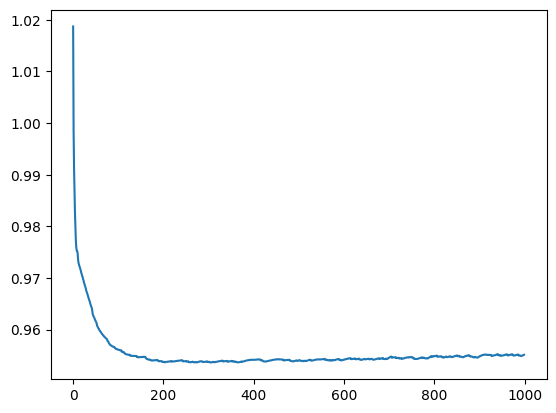

In [14]:
plt.plot(loss_list)

In [15]:
model.eval()
z, out = model(data.x, data.edge_index)

In [17]:
adata = adatas['13months-disease-replicate_1'].copy()
STAGATE_rep = z.to('cpu').detach().numpy()
adata.obsm[key_added] = STAGATE_rep

/tmp/ipykernel_79109/3697560898.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="leiden_STAGATE", resolution=0.1)


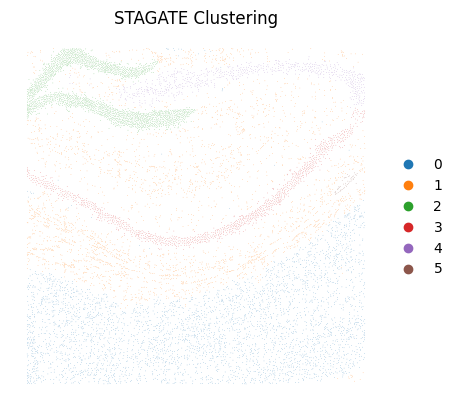

In [18]:
sc.pp.neighbors(adata, use_rep=key_added, n_neighbors=30)
sc.tl.leiden(adata, key_added="leiden_STAGATE", resolution=0.1)
sc.pl.spatial(adata, color="leiden_STAGATE", spot_size=10, title="STAGATE Clustering", ncols=3, frameon=False)

# 先尝试一下共享参数+转置矩阵

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data

class STAGATE_GAE_Tied(nn.Module):
    """
    在你的 STAGATE_GAE 基础上增加“对称参数共享”的版本。
    假设依旧使用单头 (heads=1, concat=False)，
    这样每层 GATConv 中 lin_src / lin_dst 的形状都是 [out_channels, in_channels]。
    """
    def __init__(
            self,
            in_channels: int,
            heads_per_layer: list = [1, 1],
            hidden_channels: list = [256, 256],
            dropout: float = 0.0,
    ):
        super(STAGATE_GAE_Tied, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.heads_per_layer = heads_per_layer
        self.dropout = dropout
        self.num_layers = len(hidden_channels)

        self.encoder_convs = nn.ModuleList()
        self.decoder_convs = nn.ModuleList()

        # -------- 编码器 (Encoder) --------
        for i in range(self.num_layers):
            conv_in_channels = in_channels if i == 0 else hidden_channels[i - 1]
            conv_out_channels = hidden_channels[i]
            heads = heads_per_layer[i]
            gat_conv = GATConv(
                conv_in_channels,
                conv_out_channels,
                heads=heads,
                dropout=dropout,
                add_self_loops=True,
                concat=False  # 保持 False，便于后面做转置共享
            )
            self.encoder_convs.append(gat_conv)

        # -------- 解码器 (Decoder) --------
        # “对称”指：第 i 层的输入正好是第 i 层 Encoder 的输出
        # 且输出是上一层 Encoder 的输入，这样才能做转置共享
        for i in range(self.num_layers - 1, -1, -1):
            conv_in_channels = hidden_channels[i]
            conv_out_channels = in_channels if i == 0 else hidden_channels[i - 1]
            heads = heads_per_layer[i]
            gat_conv = GATConv(
                conv_in_channels,
                conv_out_channels,
                heads=heads,
                dropout=dropout,
                add_self_loops=True,
                concat=False
            )
            self.decoder_convs.append(gat_conv)

    def forward(self, data: Data, return_hidden=False):
        """
        在 forward 中：
          1. 先依次通过 Encoder；
          2. 将 Decoder 对应层的 lin_src/lin_dst.weight = Encoder 相应层权重的转置；
          3. 再依次通过 Decoder。
        注意：self.decoder_convs[0] 对应 self.encoder_convs[-1]。
        """
        x, edge_index = data.x, data.edge_index
        hiddens_per_layer = []

        # -------- 前向：Encoder --------
        for i in range(self.num_layers):
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.encoder_convs[i](x, edge_index)
            x = F.elu(x)
            hiddens_per_layer.append(x)
        
        # 到这里，x 是最后一层 Encoder 的输出（潜在表示）

        # -------- 对称参数共享 (Tie Weights) --------
        # encoder_convs[i] <--> decoder_convs[num_layers-1-i]
        # 注意只演示 lin_* 的转置共享，attention (att) 这部分不做共享
        for i in range(self.num_layers):
            enc_layer = self.encoder_convs[i]
            dec_layer = self.decoder_convs[self.num_layers - 1 - i]
            
            # lin_src
            if enc_layer.lin_src is not None and dec_layer.lin_src is not None:
                # 将 decoder 的权重设为 encoder 的转置
                w_enc = enc_layer.lin_src.weight  # [out_enc, in_enc]
                w_dec = dec_layer.lin_src.weight  # [out_dec, in_dec]
                if w_enc is not None and w_dec is not None:
                    # 设置 data，保证梯度可以正确反传
                    # 也可以直接 dec_layer.lin_src.weight = nn.Parameter(w_enc.data.transpose(0,1))
                    dec_layer.lin_src.weight.data = w_enc.data.transpose(0, 1)

            # lin_dst（若与 lin_src 分别存在时也同理）
            if enc_layer.lin_dst is not None and dec_layer.lin_dst is not None:
                w_enc_dst = enc_layer.lin_dst.weight
                w_dec_dst = dec_layer.lin_dst.weight
                if w_enc_dst is not None and w_dec_dst is not None:
                    dec_layer.lin_dst.weight.data = w_enc_dst.data.transpose(0, 1)

        # -------- 前向：Decoder --------
        # 继续从潜在表示 x -> Decoder
        for i in range(self.num_layers):
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.decoder_convs[i](x, edge_index)
            x = F.elu(x)
            hiddens_per_layer.append(x)

        if return_hidden:
            return x, hiddens_per_layer
        else:
            return x

In [24]:
# -------------------------------
# 训练过程定义：train_STAGATE_GAE
# -------------------------------
import numpy as np
import random
from tqdm import tqdm
import torch.backends.cudnn as cudnn
cudnn.deterministic = True
cudnn.benchmark = True

def train_STAGATE_mine(graph_data: Data,
                       model = None,
                      hidden_channels=[512, 30],
                      n_epochs=1000,
                      lr=0.001,
                      weight_decay=0.0001,
                      gradient_clipping=5.0,
                      random_seed=0,
                      verbose=True,
                      device=None):
    """
    训练图注意力自编码器（STAGATE_GAE）。

    参数:
    - graph_data: torch_geometric.data.Data 对象，包含节点特征 x 和边索引 edge_index。
    - hidden_channels: 编码器各层的输出维度列表。
    - n_epochs: 总训练轮数。
    - lr: 学习率。
    - weight_decay: 权重衰减。
    - gradient_clipping: 梯度裁剪阈值。
    - random_seed: 随机种子。
    - verbose: 是否打印训练过程中日志信息。
    - device: 设备，如果为 None，则自动选择 GPU (若可用) 或 CPU。

    返回:
    - model: 训练后的模型
    - latent_rep: 节点的低维潜在表示（取自 encoder 最后一层的输出）
    - loss_list: 各轮训练损失列表
    """
    if device is None:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # 设置随机种子
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_seed)

    # 将数据移动到设备上
    graph_data = graph_data.to(device)

    # 模型初始化：in_channels 为节点特征维度
    in_channels = graph_data.x.size(-1)
    # 注意：heads_per_layer 这里设为全 1，使得每层输出维度不改变（因 concat=False）
    if model is None:
        model = STAGATE_GAE(in_channels=in_channels,
                            hidden_channels=hidden_channels,
                            heads_per_layer=[1] * len(hidden_channels),
                            dropout=0.0).to(device)
    else:
        model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_list = []

    model.train()
    for epoch in tqdm(range(1, n_epochs + 1), desc="Training"):
        optimizer.zero_grad()
        # 前向传播，获得重构后的节点特征
        out = model(graph_data)
        # 使用均方误差损失重构原始节点特征
        loss = F.mse_loss(out, graph_data.x)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
        optimizer.step()

        loss_list.append(loss.item())
        if verbose and epoch % 100 == 0:
            print(f"Epoch: {epoch:4d}, Loss: {loss.item():.4f}")

    # 训练结束后提取潜在表示
    model.eval()
    with torch.no_grad():
        # 此处采用 forward(return_hidden=True) 得到所有层的隐藏表示，
        # 我们选取 encoder 部分最后一层的输出作为节点的潜在表示
        _, hiddens = model(graph_data, return_hidden=True)
        # encoder 隐藏表示位于 hiddens[0] ~ hiddens[model.num_layers-1]
        latent_rep = hiddens[model.num_layers - 1]
    
    latent_rep_np = latent_rep.cpu().numpy()

    return model, latent_rep_np, loss_list

In [25]:
model = STAGATE_GAE_Tied(
    in_channels=data.x.size(-1),
    hidden_channels=[512, 30],  # 两层：512->512->30，再解码 30->512->512
    heads_per_layer=[1, 1],
    dropout=0.0
).to(device)

out = model(data)
print("Reconstructed shape:", out.shape)  # should be [num_nodes, in_channels]

Reconstructed shape: torch.Size([10372, 2766])


Training:  10%|█         | 102/1000 [00:05<00:49, 18.29it/s]

Epoch:  100, Loss: 0.9537


Training:  20%|██        | 202/1000 [00:11<00:43, 18.31it/s]

Epoch:  200, Loss: 0.9516


Training:  30%|███       | 302/1000 [00:16<00:38, 18.29it/s]

Epoch:  300, Loss: 0.9481


Training:  40%|████      | 402/1000 [00:21<00:32, 18.29it/s]

Epoch:  400, Loss: 0.9414


Training:  50%|█████     | 502/1000 [00:27<00:27, 18.29it/s]

Epoch:  500, Loss: 0.9360


Training:  60%|██████    | 602/1000 [00:32<00:21, 18.33it/s]

Epoch:  600, Loss: 0.9287


Training:  70%|███████   | 702/1000 [00:38<00:16, 18.30it/s]

Epoch:  700, Loss: 0.9257


Training:  80%|████████  | 802/1000 [00:43<00:10, 18.31it/s]

Epoch:  800, Loss: 0.9216


Training:  90%|█████████ | 902/1000 [00:49<00:05, 18.28it/s]

Epoch:  900, Loss: 0.9187


Training: 100%|██████████| 1000/1000 [00:54<00:00, 18.29it/s]


Epoch: 1000, Loss: 0.9189


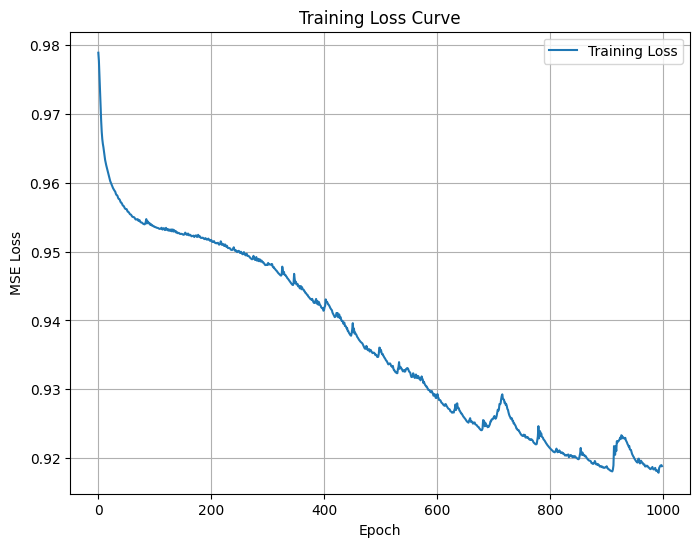

Latent representation shape: (10372, 30)


In [26]:
data = graph_data_dict['13months-disease-replicate_1'].clone()

# 调用训练过程，hidden_channels 设为 [512, 30]
model, latent_rep, loss_list = train_STAGATE_mine(
        data,
        model=model,
        hidden_channels=[512, 30],
        n_epochs=1000,  # 可根据需求增加训练轮数
        lr=0.001,
        weight_decay=0.0001,
        gradient_clipping=5.0,
        random_seed=42,
        verbose=True,
        device=device
    )

# 绘制损失曲线
plt.figure(figsize=(8, 6))
plt.plot(loss_list, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# latent_rep 即为节点的低维表示，可供后续聚类或可视化使用
print("Latent representation shape:", latent_rep.shape)

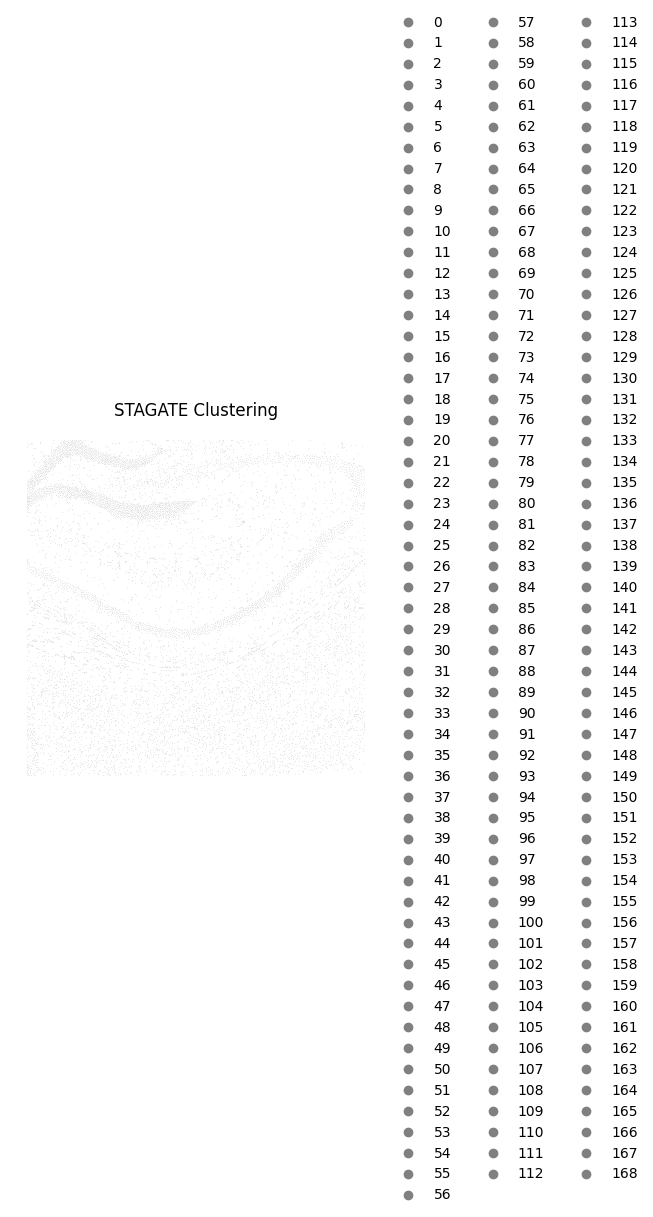

In [29]:
adata.obsm['X_STAGATE'] = latent_rep
sc.pp.neighbors(adata, use_rep="X_STAGATE", n_neighbors=30)
sc.tl.leiden(adata, key_added="leiden_STAGATE", resolution=0.01)
sc.pl.spatial(adata, color="leiden_STAGATE", spot_size=10, title="STAGATE Clustering", ncols=3, frameon=False)

# 尝试完全复刻

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch.nn import Parameter

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import (
    remove_self_loops, add_self_loops, softmax
)
from torch_sparse import SparseTensor, set_diag
from typing import Union, Tuple, Optional


class STAGATEConv(MessagePassing):
    r"""
    自定义的 STAGATEConv，核心逻辑与原版保持一致：
    - 使用手动定义的线性变换：lin_src、lin_dst
    - 注意力参数：att_src、att_dst
    - alpha = sigmoid(alpha_j + alpha_i) 后再 softmax
    - 支持 tied_attention 来“复用”已有注意力分数
    - 当 attention=False 时仅作线性映射（不更新注意力）
    """

    def __init__(
        self, 
        in_channels: int,
        out_channels: int,
        heads: int = 1,
        concat: bool = True,
        negative_slope: float = 0.2,  # 兼容保留
        dropout: float = 0.0,
        add_self_loops: bool = True,
        bias: bool = True,
        **kwargs
    ):
        """
        参数与原版相同，只是用更多的关键字进行包装。
        """
        # 'aggr' = 'add'：原版中默认累加聚合
        kwargs.setdefault('aggr', 'add')
        super(STAGATEConv, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.add_self_loops = add_self_loops

        # 手动定义的可学习参数
        # 原版是 in_channels -> heads * out_channels，但这里与原版完全对齐 (不考虑多头的话就 in->out)
        # 如果需要多头，就改成 in_channels -> heads*out_channels，再 reshape
        self.lin_src = nn.Parameter(torch.zeros((in_channels, out_channels)))
        nn.init.xavier_normal_(self.lin_src.data, gain=1.414)
        # 原版中 lin_dst = lin_src；若需要区分可以自行创建
        self.lin_dst = self.lin_src

        # 注意力参数: [1, heads, out_channels]
        self.att_src = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_dst = Parameter(torch.Tensor(1, heads, out_channels))
        nn.init.xavier_normal_(self.att_src, gain=1.414)
        nn.init.xavier_normal_(self.att_dst, gain=1.414)

        # 是否添加 bias
        if bias:
            if concat:
                self.bias = Parameter(torch.Tensor(heads * out_channels))
            else:
                self.bias = Parameter(torch.Tensor(out_channels))
            nn.init.zeros_(self.bias)
        else:
            self.register_parameter('bias', None)

        # 用来临时保存注意力
        self._alpha = None
        # 存储本层计算出来的 alpha_src/alpha_dst
        self.attentions = None

    def forward(
        self,
        x: Tensor,
        edge_index: Union[Tensor, SparseTensor],
        size: Optional[Tuple[int, int]] = None,
        return_attention_weights: bool = False,
        attention: bool = True,
        tied_attention: Optional[Tuple[Tensor, Tensor]] = None
    ):
        """
        与原版相同，x: [num_nodes, in_channels]
        """
        # 只支持 x 为 Tensor（对 bipartite 这里不再演示）
        assert isinstance(x, Tensor), "Static graphs not supported in 'STAGATEConv'"

        # 先做线性变换
        # 如果 heads=1，可以直接 [N, in_channels] x [in_channels, out_channels] = [N, out_channels]
        # 若 heads>1，需要 reshape -> [N, heads, out_channels]
        if self.heads == 1:
            x_src = torch.mm(x, self.lin_src)  # [N, out_channels]
            x_src = x_src.unsqueeze(1)         # [N, 1, out_channels]
            x_dst = x_src
        else:
            # in_channels -> heads * out_channels
            # 这里要预先把 lin_src 改成 [in_channels, heads*out_channels] 再 reshape
            raise NotImplementedError("多头情况请自行完善同原版一致")

        # 如果不需要计算注意力，直接返回线性映射结果
        if not attention:
            # 与原版一样，要把多头结果合并起来
            if self.concat and self.heads > 1:
                out_no_att = x_src.reshape(-1, self.heads * self.out_channels)
                return out_no_att
            else:
                # single-head 或者 mean
                out_no_att = x_src.mean(dim=1)  # single-head 就相当于 squeeze
                return out_no_att

        # 处理 tied_attention
        if tied_attention is None:
            # alpha_src, alpha_dst = (x_src * att_src).sum(dim=-1), (x_dst * att_dst).sum(dim=-1)
            # 但原版默认 x_src=x_dst，所以 alpha_dst = alpha_src * att_dst
            alpha_src = (x_src * self.att_src).sum(dim=-1)  # [N, heads]
            alpha_dst = (x_dst * self.att_dst).sum(dim=-1) if x_dst is not None else None
            self.attentions = (alpha_src, alpha_dst)
        else:
            # 复用其他层的注意力 (alpha_src, alpha_dst)
            alpha_src, alpha_dst = tied_attention

        # 根据是否加 self-loop
        if self.add_self_loops:
            if isinstance(edge_index, Tensor):
                num_nodes = x.size(0)
                edge_index, _ = remove_self_loops(edge_index)
                edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)
            elif isinstance(edge_index, SparseTensor):
                edge_index = set_diag(edge_index)

        # 调用 propagate
        out = self.propagate(
            edge_index, 
            x=(x_src, x_dst), 
            alpha=(alpha_src, alpha_dst),
            size=size
        )

        alpha = self._alpha
        self._alpha = None  # 用完就清空

        # 拼接或者平均
        if self.concat and self.heads > 1:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)

        # bias
        if self.bias is not None:
            out = out + self.bias

        if return_attention_weights:
            return out, (edge_index, alpha)
        else:
            return out

    def message(self, x_j: Tensor, alpha: Tuple[Tensor, Optional[Tensor]], index: Tensor, ptr: Optional[Tensor], size_i: Optional[int]):
        alpha_src, alpha_dst = alpha
        # 手动根据 edge_index 分别采集源节点与目标节点对应的注意力分数
        alpha_j = alpha_src[index[0]]  # 假设 index[0] 是源节点索引
        if alpha_dst is not None:
            alpha_i = alpha_dst[index[1]]  # 假设 index[1] 是目标节点索引
            alpha_ij = alpha_j + alpha_i
        else:
            alpha_ij = alpha_j
        alpha_ij = torch.sigmoid(alpha_ij)
        alpha_ij = softmax(alpha_ij, index[1] if alpha_dst is not None else index, ptr, size_i)
        self._alpha = alpha_ij
        alpha_ij = F.dropout(alpha_ij, p=self.dropout, training=self.training)
        return x_j * alpha_ij.unsqueeze(-1)


    def __repr__(self):
        return (
            f"{self.__class__.__name__}("
            f"{self.in_channels}, {self.out_channels}, heads={self.heads}, "
            f"concat={self.concat}, dropout={self.dropout})"
        )


class STAGATE(nn.Module):
    r"""
    与原版类似，包含四层“对称”结构：
    1) conv1: in_dim -> num_hidden
    2) conv2: num_hidden -> out_dim
    3) conv3: out_dim -> num_hidden (与 conv2 参数转置共享)
    4) conv4: num_hidden -> in_dim  (与 conv1 参数转置共享)

    并在 forward 中：
    - h2 = conv2(h1, attention=False)
    - conv3 用 tied_attention=conv1.attentions
    - conv4 attention=False

    这样即保留了原版的做法。
    """

    def __init__(self, in_dim: int, num_hidden: int, out_dim: int):
        super(STAGATE, self).__init__()

        # 初始化四层
        self.conv1 = STAGATEConv(
            in_channels=in_dim,
            out_channels=num_hidden,
            heads=1,
            concat=False,
            dropout=0.0,
            add_self_loops=False,
            bias=False
        )
        self.conv2 = STAGATEConv(
            in_channels=num_hidden,
            out_channels=out_dim,
            heads=1,
            concat=False,
            dropout=0.0,
            add_self_loops=False,
            bias=False
        )
        self.conv3 = STAGATEConv(
            in_channels=out_dim,
            out_channels=num_hidden,
            heads=1,
            concat=False,
            dropout=0.0,
            add_self_loops=False,
            bias=False
        )
        self.conv4 = STAGATEConv(
            in_channels=num_hidden,
            out_channels=in_dim,
            heads=1,
            concat=False,
            dropout=0.0,
            add_self_loops=False,
            bias=False
        )

    def forward(self, x: Tensor, edge_index: Tensor):
        # 1) conv1
        h1 = F.elu(self.conv1(x, edge_index, attention=True))  # 这里默认 attention=True
        # 2) conv2
        h2 = self.conv2(h1, edge_index, attention=False)       # 原版对第二层关闭注意力

        # 下面是权重共享: conv3 使用 conv2 的转置, conv4 使用 conv1 的转置
        self.conv3.lin_src.data = self.conv2.lin_src.transpose(0, 1)
        self.conv3.lin_dst.data = self.conv2.lin_dst.transpose(0, 1)
        self.conv4.lin_src.data = self.conv1.lin_src.transpose(0, 1)
        self.conv4.lin_dst.data = self.conv1.lin_dst.transpose(0, 1)

        # 3) conv3
        # tied_attention 指定使用 conv1 的 alpha，而不自己重新计算
        h3 = F.elu(
            self.conv3(
                h2, 
                edge_index, 
                attention=True,
                tied_attention=self.conv1.attentions
            )
        )
        # 4) conv4
        h4 = self.conv4(h3, edge_index, attention=False)

        return h2, h4


In [19]:
data

Data(x=[10372, 2766], edge_index=[2, 274350])

In [20]:
# Try a single forward pass
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_data = data.clone()

model = STAGATE(
    in_dim=test_data.x.size(-1),
    num_hidden=512,
    out_dim=30
).to(device)

test_data = test_data.to(device)

model(test_data.x, test_data.edge_index)


ValueError: The `index` argument must be one-dimensional (got 0 dimensions)

# Ablation Study

In [36]:
graph_data = graph_data_dict['8months-disease-replicate_1'].clone()
adata = adatas['8months-disease-replicate_1'].copy()


========== Running Original ==========


<Figure size 600x600 with 0 Axes>

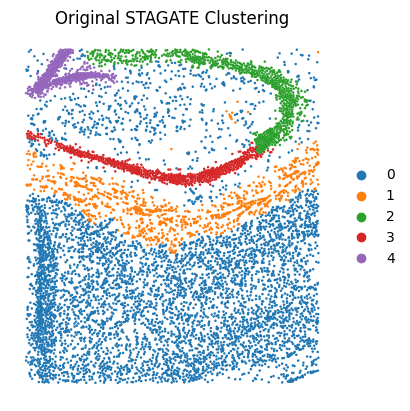

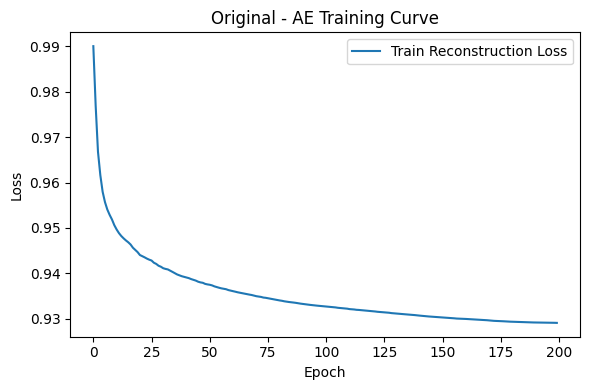

========== Running Ablation_remove_attention ==========


<Figure size 600x600 with 0 Axes>

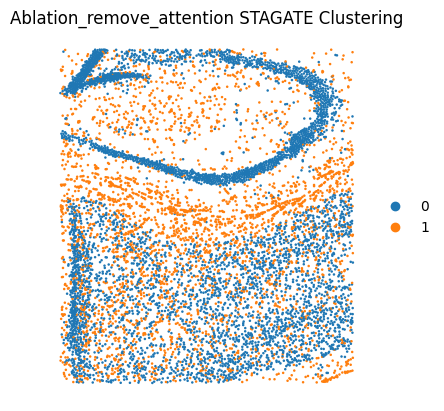

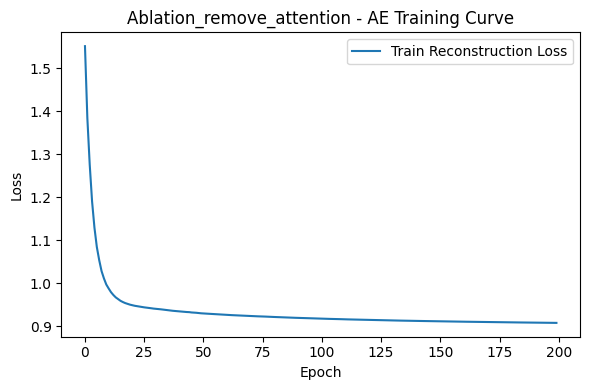

========== Running Ablation_remove_tied_attention ==========


<Figure size 600x600 with 0 Axes>

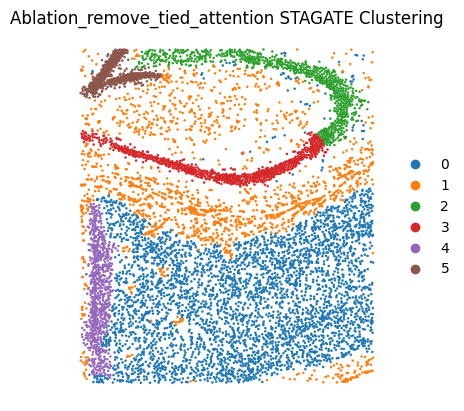

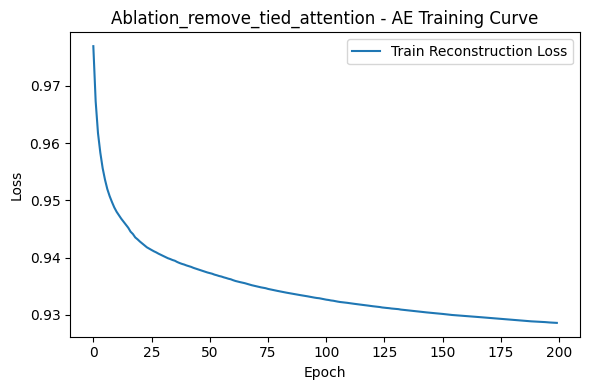

========== Running Ablation_use_leaky_relu ==========


<Figure size 600x600 with 0 Axes>

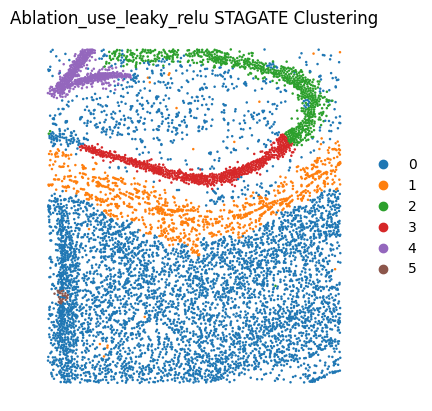

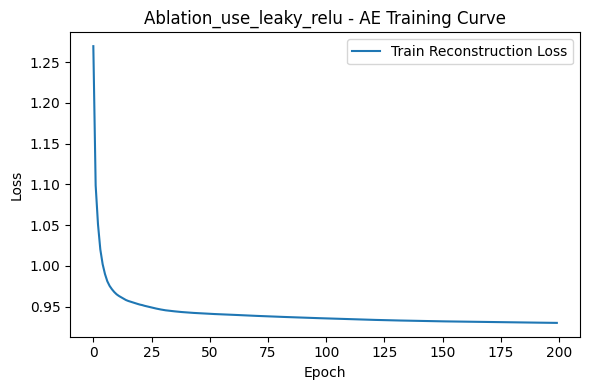

========== Running Ablation_remove_weight_transpose ==========


<Figure size 600x600 with 0 Axes>

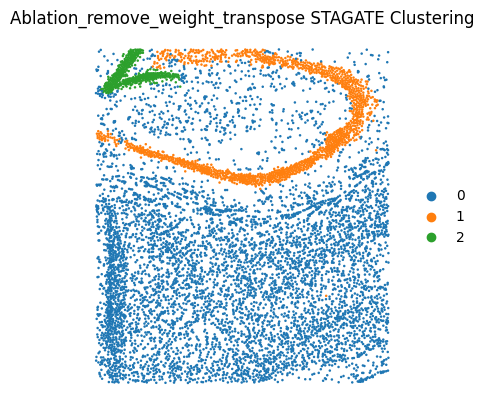

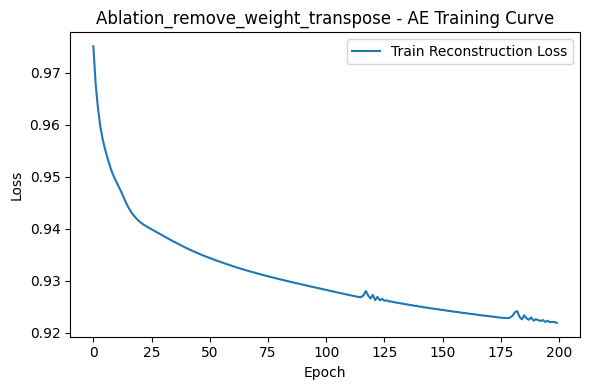

========== Running Ablation_use_standard_linear ==========


<Figure size 600x600 with 0 Axes>

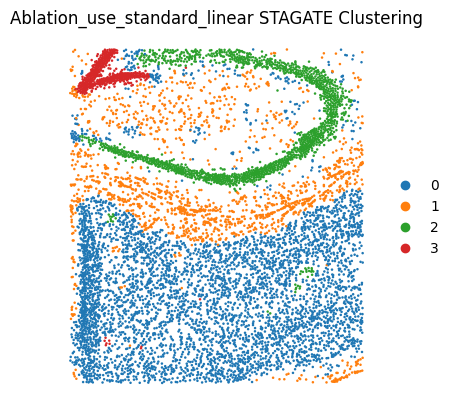

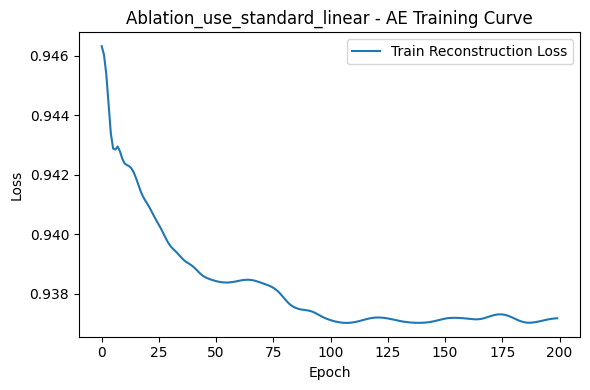


========= 单一消融 + 原始 的最终结果对比 =========
                      ablation_name  final_loss
0                          Original    0.929061
1         Ablation_remove_attention    0.908095
2    Ablation_remove_tied_attention    0.928617
3           Ablation_use_leaky_relu    0.930177
4  Ablation_remove_weight_transpose    0.921923
5      Ablation_use_standard_linear    0.937181


In [41]:
########################################
#  1. 环境准备与导入
########################################

# 如果在Notebook中，需要时可取消注释后安装
# %pip install torch torchvision torchaudio
# %pip install torch-geometric
# %pip install scanpy
# %pip install tensorboard
# %pip install pandas

import os
import copy
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

import scanpy as sc
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax
from torch_geometric.nn import MessagePassing
from torch.nn import Parameter
from torch.utils.tensorboard import SummaryWriter

# 如果在Notebook中，需要内嵌绘图
%matplotlib inline

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 准备输出目录
os.makedirs("./ablation_test", exist_ok=True)


########################################
#  2. 定义可选消融的 STAGATEConv
########################################

class STAGATEConv(MessagePassing):
    """
    自定义的 GAT-like 算法，用于 STAGATE AE。
    通过 ablation_flags 字典中的布尔值控制是否启用某些模块或更改激活。
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 ablation_flags=None,
                 heads=1,
                 concat=False,
                 negative_slope=0.2,
                 dropout=0.0,
                 add_self_loops=True,
                 bias=False):
        super().__init__(node_dim=0, aggr='add')

        if ablation_flags is None:
            ablation_flags = {}
        self.ablation_flags = ablation_flags

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.add_self_loops = add_self_loops

        # (Ablation) 是否使用标准 Linear
        if self.ablation_flags.get("use_standard_linear", False):
            self.lin_src = torch.nn.Linear(in_channels, out_channels, bias=False)
            self.lin_dst = self.lin_src
        else:
            # 与题主类似的自定义参数
            self.lin_src = Parameter(torch.zeros(size=(in_channels, out_channels)))
            torch.nn.init.xavier_normal_(self.lin_src.data, gain=1.414)
            self.lin_dst = self.lin_src

        # 注意力参数
        self.att_src = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_dst = Parameter(torch.Tensor(1, heads, out_channels))
        torch.nn.init.xavier_normal_(self.att_src.data, gain=1.414)
        torch.nn.init.xavier_normal_(self.att_dst.data, gain=1.414)

        # 缓存中间注意力
        self._alpha = None
        self.attentions = None

    def forward(self, x, edge_index, attention=True, tied_attention=None):
        # 若 remove_attention 则不执行注意力机制
        if self.ablation_flags.get("remove_attention", False):
            attention = False

        H, C = self.heads, self.out_channels

        # 线性变换
        if isinstance(self.lin_src, torch.nn.Linear):
            x_src = self.lin_src(x).view(-1, H, C)
            x_dst = x_src
        else:
            x_src = torch.mm(x, self.lin_src).view(-1, H, C)
            x_dst = x_src

        if not attention:
            # 不做注意力，直接返回均值
            return x_src.mean(dim=1)

        # 如果没有共享其他层的注意力，则自己计算
        if tied_attention is None:
            alpha_src = (x_src * self.att_src).sum(dim=-1)
            alpha_dst = (x_dst * self.att_dst).sum(dim=-1)
            alpha = (alpha_src, alpha_dst)
            self.attentions = alpha
        else:
            alpha = tied_attention

        # 加自环
        if self.add_self_loops:
            num_nodes = x_src.size(0)
            edge_index, _ = remove_self_loops(edge_index)
            edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)

        out = self.propagate(edge_index, x=(x_src, x_dst), alpha=alpha)
        alpha = self._alpha
        self._alpha = None

        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)
        return out

    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):
        # 将source、target的alpha相加
        alpha = alpha_j if alpha_i is None else alpha_j + alpha_i

        # 是否使用leaky_relu还是sigmoid
        if self.ablation_flags.get("use_leaky_relu", False):
            alpha = F.leaky_relu(alpha, negative_slope=self.negative_slope)
        else:
            alpha = torch.sigmoid(alpha)

        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return x_j * alpha.unsqueeze(-1)


########################################
#  3. 定义 STAGATE 自编码器
########################################

class STAGATE(torch.nn.Module):
    def __init__(self, hidden_dims, ablation_flags=None):
        super().__init__()
        if ablation_flags is None:
            ablation_flags = {}

        [in_dim, num_hidden, out_dim] = hidden_dims
        self.ablation_flags = ablation_flags

        self.conv1 = STAGATEConv(in_dim, num_hidden,
                                 ablation_flags=ablation_flags,
                                 heads=1, concat=False,
                                 dropout=0, add_self_loops=False, bias=False)
        self.conv2 = STAGATEConv(num_hidden, out_dim,
                                 ablation_flags=ablation_flags,
                                 heads=1, concat=False,
                                 dropout=0, add_self_loops=False, bias=False)
        self.conv3 = STAGATEConv(out_dim, num_hidden,
                                 ablation_flags=ablation_flags,
                                 heads=1, concat=False,
                                 dropout=0, add_self_loops=False, bias=False)
        self.conv4 = STAGATEConv(num_hidden, in_dim,
                                 ablation_flags=ablation_flags,
                                 heads=1, concat=False,
                                 dropout=0, add_self_loops=False, bias=False)

    def forward(self, x, edge_index):
        # 第一层
        h1 = F.elu(self.conv1(x, edge_index, attention=not self.ablation_flags.get("remove_attention", False)))
        # 第二层 (不带注意力)
        h2 = self.conv2(h1, edge_index, attention=False)

        # 如果不移除权重转置共享，则执行
        if not self.ablation_flags.get("remove_weight_transpose", False):
            if isinstance(self.conv2.lin_src, torch.nn.Linear):
                # conv2.lin_src.weight.shape = [out_dim, in_dim]
                # conv3.lin_src.weight.shape = [num_hidden, out_dim] （若定义和编码器对称）
                # 如果想要conv3的权重是conv2的转置，则：
                self.conv3.lin_src.weight.data = self.conv2.lin_src.weight.data.transpose(0, 1).clone()
                self.conv3.lin_dst.weight.data = self.conv2.lin_dst.weight.data.transpose(0, 1).clone()

                # 同理
                self.conv4.lin_src.weight.data = self.conv1.lin_src.weight.data.transpose(0, 1).clone()
                self.conv4.lin_dst.weight.data = self.conv1.lin_dst.weight.data.transpose(0, 1).clone()
            else:
                # 否则是原来的 Parameter 情况
                self.conv3.lin_src.data = self.conv2.lin_src.transpose(0, 1)
                self.conv3.lin_dst.data = self.conv2.lin_dst.transpose(0, 1)
                self.conv4.lin_src.data = self.conv1.lin_src.transpose(0, 1)
                self.conv4.lin_dst.data = self.conv1.lin_dst.transpose(0, 1)

        # tied_attention
        tied_attention = None
        if not self.ablation_flags.get("remove_tied_attention", False):
            tied_attention = self.conv1.attentions

        # 第三层
        h3 = F.elu(self.conv3(h2, edge_index, attention=not self.ablation_flags.get("remove_attention", False),
                              tied_attention=tied_attention))
        # 第四层
        h4 = self.conv4(h3, edge_index, attention=False)

        return h2, h4


########################################
#  4. 训练与评估 (AutoEncoder)
########################################

def train_and_evaluate_ae(
    ablation_name,
    ablation_flags,
    graph_data,
    adata,
    num_epochs=200,
    lr=1e-3,
    weight_decay=1e-5,
    save_dir="./ablation_test"
):
    """
    训练STAGATE自编码器，并将中间隐层写回adata.obsm['X_STAGATE']；
    然后使用scanpy进行聚类、可视化。
    """
    writer_dir = os.path.join(save_dir, ablation_name)
    os.makedirs(writer_dir, exist_ok=True)
    writer = SummaryWriter(log_dir=writer_dir)

    # 准备数据
    x = graph_data.x.to(device)
    edge_index = graph_data.edge_index.to(device)

    in_dim = x.shape[1]
    hidden_dims = [in_dim, 64, 32]  # 可视需求修改
    model = STAGATE(hidden_dims, ablation_flags=ablation_flags).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # 前向：得到中间表示 h2 与重构输出 h4
        h2, h4 = model(x, edge_index)
        # 重构损失
        loss = F.mse_loss(h4, x)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        writer.add_scalar("Loss/train", loss.item(), epoch)

    writer.close()

    # 训练结束后，获取最终表示
    model.eval()
    with torch.no_grad():
        h2, h4 = model(x, edge_index)
    latent_rep = h2.detach().cpu().numpy()

    # 写回 adata.obsm
    adata.obsm['X_STAGATE'] = latent_rep

    # scanpy 聚类 & 可视化
    sc.pp.neighbors(adata, use_rep="X_STAGATE", n_neighbors=30)
    sc.tl.leiden(adata, key_added="leiden_STAGATE", resolution=0.1)

    # 保存聚类图
    plt.figure(figsize=(6,6))
    sc.pl.spatial(
        adata,
        color="leiden_STAGATE",
        spot_size=50,
        ncols=1,
        frameon=False,
        show=False,
        title=f"{ablation_name} STAGATE Clustering"
    )
    pdf_path = os.path.join(save_dir, f"{ablation_name}_clustering.pdf")
    plt.savefig(pdf_path, bbox_inches='tight')
    plt.show()

    # 保存训练曲线图
    plt.figure(figsize=(6,4))
    plt.plot(range(num_epochs), train_losses, label='Train Reconstruction Loss')
    plt.title(f"{ablation_name} - AE Training Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    pdf_loss_path = os.path.join(save_dir, f"{ablation_name}_loss.pdf")
    plt.savefig(pdf_loss_path)
    plt.show()

    # 返回结果
    return {
        "ablation_name": ablation_name,
        "final_loss": train_losses[-1]
    }


########################################
#  5. 逐一遍历“去除一个组件”的所有可能性 + 原始
########################################

# 需要您自己准备以下对象:
# graph_data = ...
# adata      = ...

# 示例：假设您有 graph_data, adata
# graph_data = your_graph_dict['8months-disease-replicate_1']
# adata      = adatas['8months-disease-replicate_1']
# 这里假设它们已准备好:
# ----------------------------------
# graph_data = ...
# adata = ...
# ----------------------------------

# 我们的五项可选消融:
#  1) remove_attention
#  2) remove_tied_attention
#  3) use_leaky_relu
#  4) remove_weight_transpose
#  5) use_standard_linear

# 为了“遍历去除一个”的所有可能性，并且还包含原始不去除的对照，共计6项：
experiments = [
    {
        "name": "Original",
        "flags": {
            "remove_attention": False,
            "remove_tied_attention": False,
            "use_leaky_relu": False,
            "remove_weight_transpose": False,
            "use_standard_linear": False
        }
    },
    {
        "name": "Ablation_remove_attention",
        "flags": {
            "remove_attention": True,
            "remove_tied_attention": False,
            "use_leaky_relu": False,
            "remove_weight_transpose": False,
            "use_standard_linear": False
        }
    },
    {
        "name": "Ablation_remove_tied_attention",
        "flags": {
            "remove_attention": False,
            "remove_tied_attention": True,
            "use_leaky_relu": False,
            "remove_weight_transpose": False,
            "use_standard_linear": False
        }
    },
    {
        "name": "Ablation_use_leaky_relu",
        "flags": {
            "remove_attention": False,
            "remove_tied_attention": False,
            "use_leaky_relu": True,
            "remove_weight_transpose": False,
            "use_standard_linear": False
        }
    },
    {
        "name": "Ablation_remove_weight_transpose",
        "flags": {
            "remove_attention": False,
            "remove_tied_attention": False,
            "use_leaky_relu": False,
            "remove_weight_transpose": True,
            "use_standard_linear": False
        }
    },
    {
        "name": "Ablation_use_standard_linear",
        "flags": {
            "remove_attention": False,
            "remove_tied_attention": False,
            "use_leaky_relu": False,
            "remove_weight_transpose": False,
            "use_standard_linear": True
        }
    },
]

results = []
for exp in experiments:
    print(f"========== Running {exp['name']} ==========")
    res = train_and_evaluate_ae(
        ablation_name=exp["name"],
        ablation_flags=exp["flags"],
        graph_data=graph_data,
        adata=adata,
        num_epochs=200,     # 可自行调整
        lr=1e-3,            # 可自行调整
        weight_decay=1e-5,  # 可自行调整
        save_dir="./ablation_test"
    )
    results.append(res)

# 最终结果统计
df = pd.DataFrame(results)
print("\n========= 单一消融 + 原始 的最终结果对比 =========")
print(df)


========== Running Original ==========


<Figure size 600x600 with 0 Axes>

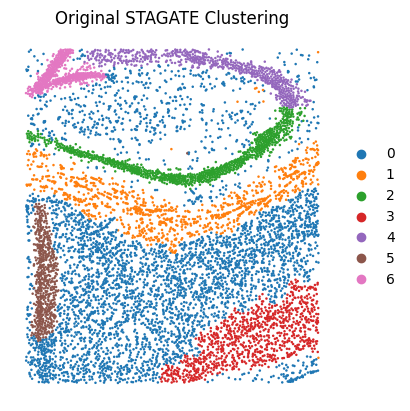

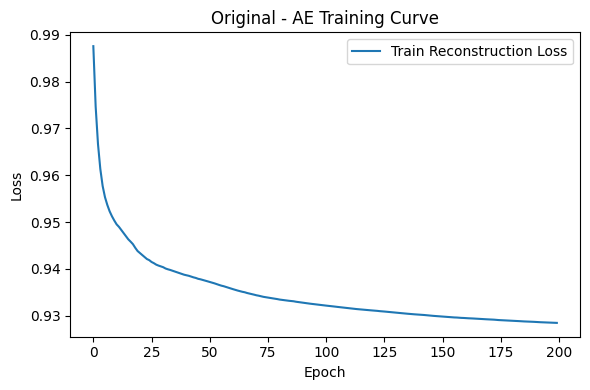

========== Running Ablation_remove_attention ==========


<Figure size 600x600 with 0 Axes>

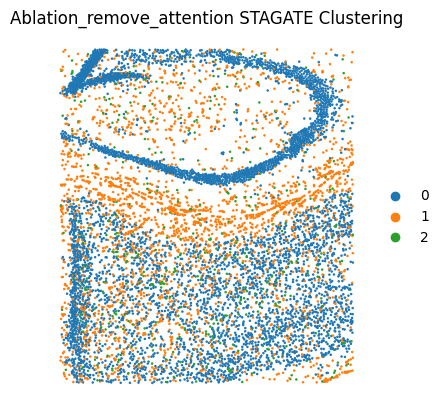

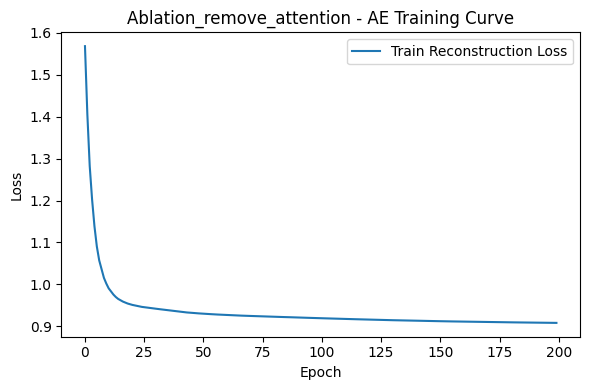

========== Running Ablation_remove_tied_attention ==========


<Figure size 600x600 with 0 Axes>

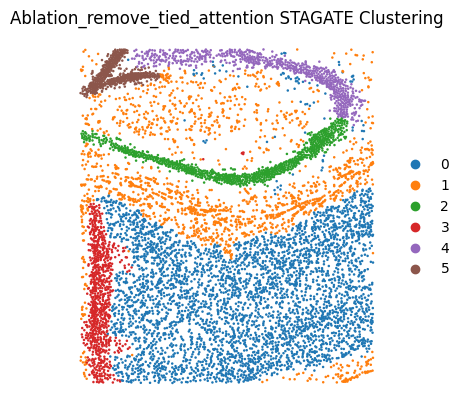

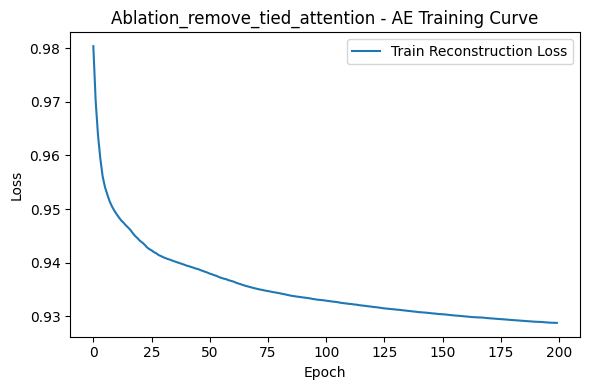

========== Running Ablation_use_leaky_relu ==========


<Figure size 600x600 with 0 Axes>

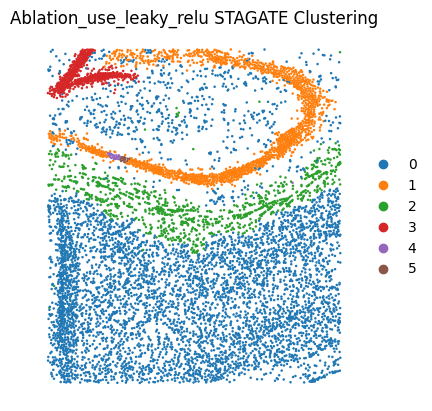

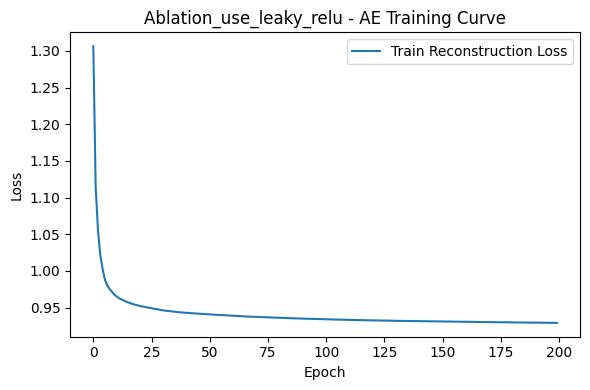

========== Running Ablation_remove_weight_transpose ==========


<Figure size 600x600 with 0 Axes>

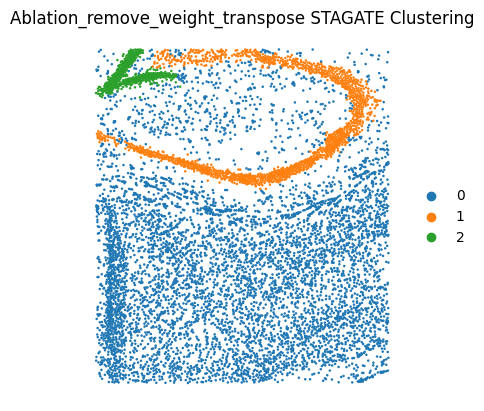

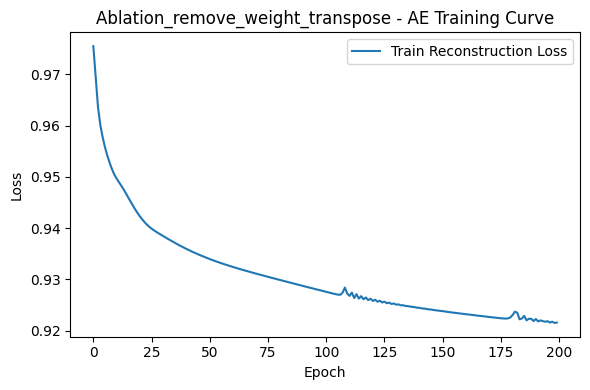

========== Running Ablation_use_standard_linear ==========


<Figure size 600x600 with 0 Axes>

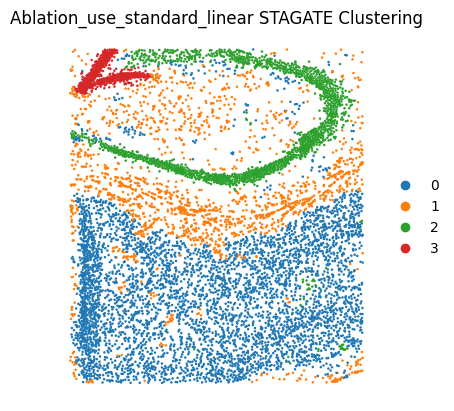

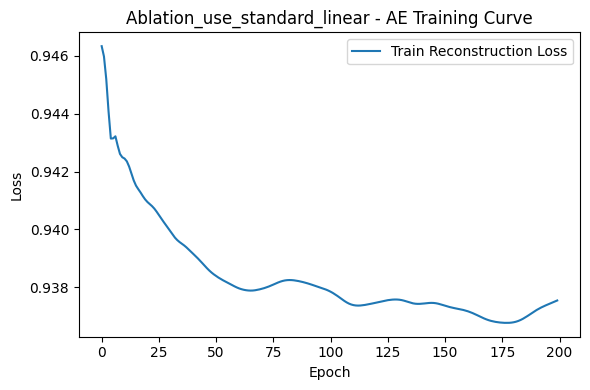

========== Running Ablation_use_pyg_gatconv ==========


<Figure size 600x600 with 0 Axes>

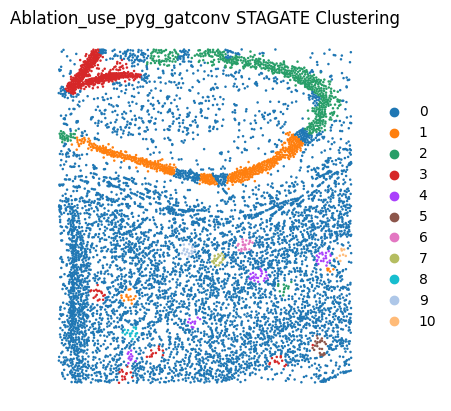

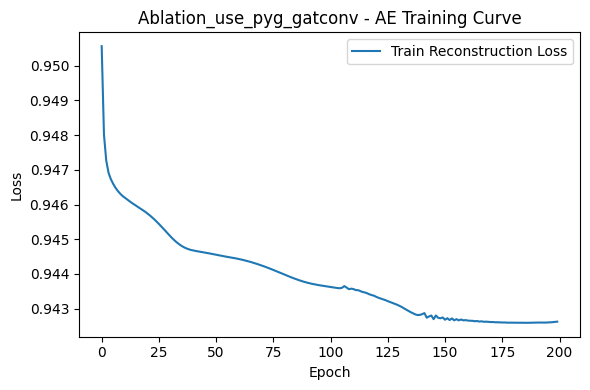


========= 单一消融 + 原始 + PyG GATConv 的最终结果对比 =========


ablation_name  final_loss
0                          Original    0.928496
1         Ablation_remove_attention    0.908185
2    Ablation_remove_tied_attention    0.928786
3           Ablation_use_leaky_relu    0.929245
4  Ablation_remove_weight_transpose    0.921562
5      Ablation_use_standard_linear    0.937542
6          Ablation_use_pyg_gatconv    0.942627

In [44]:
########################################
#  1. 环境准备与导入
########################################

# 如果在Notebook中，需要时可取消注释后安装
# %pip install torch torchvision torchaudio
# %pip install torch-geometric
# %pip install scanpy
# %pip install tensorboard
# %pip install pandas

import os
import copy
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

import scanpy as sc
from torch_geometric.utils import remove_self_loops, add_self_loops
from torch_geometric.nn import MessagePassing, GATConv
from torch.nn import Parameter
from torch.utils.tensorboard import SummaryWriter

# 如果在Notebook中，需要内嵌绘图
%matplotlib inline

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 准备输出目录
os.makedirs("./ablation_test", exist_ok=True)


########################################
#  2. 定义可选消融的自定义 STAGATEConv
########################################

class STAGATEConv(MessagePassing):
    """
    自定义的 GAT-like 算法，用于 STAGATE AE。
    通过 ablation_flags 字典中的布尔值控制是否启用某些模块或更改激活。
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 ablation_flags=None,
                 heads=1,
                 concat=False,
                 negative_slope=0.2,
                 dropout=0.0,
                 add_self_loops=True,
                 bias=False):
        super().__init__(node_dim=0, aggr='add')

        if ablation_flags is None:
            ablation_flags = {}
        self.ablation_flags = ablation_flags

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.add_self_loops = add_self_loops

        # (Ablation) 是否使用标准 Linear
        if self.ablation_flags.get("use_standard_linear", False):
            self.lin_src = torch.nn.Linear(in_channels, out_channels, bias=False)
            self.lin_dst = self.lin_src
        else:
            # 与题主类似的自定义参数
            self.lin_src = Parameter(torch.zeros(size=(in_channels, out_channels)))
            torch.nn.init.xavier_normal_(self.lin_src.data, gain=1.414)
            self.lin_dst = self.lin_src

        # 注意力参数
        self.att_src = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_dst = Parameter(torch.Tensor(1, heads, out_channels))
        torch.nn.init.xavier_normal_(self.att_src.data, gain=1.414)
        torch.nn.init.xavier_normal_(self.att_dst.data, gain=1.414)

        # 缓存中间注意力
        self._alpha = None
        self.attentions = None

    def forward(self, x, edge_index, attention=True, tied_attention=None):
        # 若 remove_attention 则不执行注意力机制
        if self.ablation_flags.get("remove_attention", False):
            attention = False

        H, C = self.heads, self.out_channels

        # 线性变换
        if isinstance(self.lin_src, torch.nn.Linear):
            x_src = self.lin_src(x).view(-1, H, C)
            x_dst = x_src
        else:
            x_src = torch.mm(x, self.lin_src).view(-1, H, C)
            x_dst = x_src

        if not attention:
            # 不做注意力，直接返回均值
            return x_src.mean(dim=1)

        # 如果没有共享其他层的注意力，则自己计算
        if tied_attention is None:
            alpha_src = (x_src * self.att_src).sum(dim=-1)
            alpha_dst = (x_dst * self.att_dst).sum(dim=-1)
            alpha = (alpha_src, alpha_dst)
            self.attentions = alpha
        else:
            alpha = tied_attention

        # 加自环
        if self.add_self_loops:
            num_nodes = x_src.size(0)
            edge_index, _ = remove_self_loops(edge_index)
            edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)

        out = self.propagate(edge_index, x=(x_src, x_dst), alpha=alpha)
        alpha = self._alpha
        self._alpha = None

        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)
        return out

    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):
        # 将source、target的alpha相加
        alpha = alpha_j if alpha_i is None else alpha_j + alpha_i

        # 是否使用leaky_relu还是sigmoid
        if self.ablation_flags.get("use_leaky_relu", False):
            alpha = F.leaky_relu(alpha, negative_slope=self.negative_slope)
        else:
            alpha = torch.sigmoid(alpha)

        from torch_geometric.utils import softmax
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return x_j * alpha.unsqueeze(-1)


########################################
#  3A. 定义自定义 STAGATE 模型 (使用 STAGATEConv)
########################################

class STAGATE(torch.nn.Module):
    def __init__(self, hidden_dims, ablation_flags=None):
        super().__init__()
        if ablation_flags is None:
            ablation_flags = {}

        [in_dim, num_hidden, out_dim] = hidden_dims
        self.ablation_flags = ablation_flags

        self.conv1 = STAGATEConv(in_dim, num_hidden,
                                 ablation_flags=ablation_flags,
                                 heads=1, concat=False,
                                 dropout=0, add_self_loops=False, bias=False)
        self.conv2 = STAGATEConv(num_hidden, out_dim,
                                 ablation_flags=ablation_flags,
                                 heads=1, concat=False,
                                 dropout=0, add_self_loops=False, bias=False)
        self.conv3 = STAGATEConv(out_dim, num_hidden,
                                 ablation_flags=ablation_flags,
                                 heads=1, concat=False,
                                 dropout=0, add_self_loops=False, bias=False)
        self.conv4 = STAGATEConv(num_hidden, in_dim,
                                 ablation_flags=ablation_flags,
                                 heads=1, concat=False,
                                 dropout=0, add_self_loops=False, bias=False)

    def forward(self, x, edge_index):
        # 第一层
        h1 = F.elu(self.conv1(x, edge_index,
                              attention=not self.ablation_flags.get("remove_attention", False)))
        # 第二层 (不带注意力)
        h2 = self.conv2(h1, edge_index, attention=False)

        # 如果不移除权重转置共享，则执行
        if not self.ablation_flags.get("remove_weight_transpose", False):
            # 当 conv2.lin_src 是 nn.Linear 时，需要对 weight 做 transpose
            if isinstance(self.conv2.lin_src, torch.nn.Linear):
                self.conv3.lin_src.weight.data = self.conv2.lin_src.weight.data.transpose(0, 1).clone()
                self.conv3.lin_dst.weight.data = self.conv2.lin_dst.weight.data.transpose(0, 1).clone()

                self.conv4.lin_src.weight.data = self.conv1.lin_src.weight.data.transpose(0, 1).clone()
                self.conv4.lin_dst.weight.data = self.conv1.lin_dst.weight.data.transpose(0, 1).clone()
            else:
                self.conv3.lin_src.data = self.conv2.lin_src.transpose(0, 1)
                self.conv3.lin_dst.data = self.conv2.lin_dst.transpose(0, 1)
                self.conv4.lin_src.data = self.conv1.lin_src.transpose(0, 1)
                self.conv4.lin_dst.data = self.conv1.lin_dst.transpose(0, 1)

        # tied_attention
        tied_attention = None
        if not self.ablation_flags.get("remove_tied_attention", False):
            tied_attention = self.conv1.attentions

        # 第三层
        h3 = F.elu(self.conv3(h2, edge_index,
                              attention=not self.ablation_flags.get("remove_attention", False),
                              tied_attention=tied_attention))
        # 第四层
        h4 = self.conv4(h3, edge_index, attention=False)

        return h2, h4


########################################
#  3B. 定义基于 PyG GATConv 的 STAGATE 模型
########################################

class STAGATE_PyGGAT(torch.nn.Module):
    """
    使用 PyG 原生 GATConv 来实现 4 层 Encoder-Decoder，并保留“权重转置共享”思路。
    """
    def __init__(self, hidden_dims, ablation_flags=None):
        super().__init__()
        if ablation_flags is None:
            ablation_flags = {}

        [in_dim, num_hidden, out_dim] = hidden_dims
        self.ablation_flags = ablation_flags

        # heads=1, concat=False, add_self_loops=False 等，与自定义保持一致
        self.conv1 = GATConv(in_dim, num_hidden, heads=1, concat=False,
                             dropout=0, add_self_loops=False, bias=False)
        self.conv2 = GATConv(num_hidden, out_dim, heads=1, concat=False,
                             dropout=0, add_self_loops=False, bias=False)
        self.conv3 = GATConv(out_dim, num_hidden, heads=1, concat=False,
                             dropout=0, add_self_loops=False, bias=False)
        self.conv4 = GATConv(num_hidden, in_dim, heads=1, concat=False,
                             dropout=0, add_self_loops=False, bias=False)

    def forward(self, x, edge_index):
        # Encoder
        h1 = F.elu(self.conv1(x, edge_index))
        h2 = self.conv2(h1, edge_index)

        # 如果不移除权重转置共享，则执行
        # GATConv 中只有 self.lin (是 PyG 的 Linear)，
        # 其权重可通过 self.conv2.lin.weight 访问，形状 (out_dim, num_hidden) 。
        if not self.ablation_flags.get("remove_weight_transpose", False):
            # conv2 -> conv3
            self.conv3.lin.weight.data = self.conv2.lin.weight.data.transpose(0, 1).clone()
            # conv1 -> conv4
            self.conv4.lin.weight.data = self.conv1.lin.weight.data.transpose(0, 1).clone()

        # Decoder
        h3 = F.elu(self.conv3(h2, edge_index))
        h4 = self.conv4(h3, edge_index)

        return h2, h4


########################################
#  4. 训练与评估 (AutoEncoder)
########################################

def train_and_evaluate_ae(
    ablation_name,
    ablation_flags,
    graph_data,
    adata,
    num_epochs=200,
    lr=1e-3,
    weight_decay=1e-5,
    save_dir="./ablation_test"
):
    """
    训练STAGATE自编码器，并将中间隐层写回adata.obsm['X_STAGATE']；
    然后使用scanpy进行聚类、可视化。
    如果 ablation_flags["use_pyg_gatconv"] 为 True，使用 PyG GATConv，否则用自定义 STAGATEConv。
    """
    writer_dir = os.path.join(save_dir, ablation_name)
    os.makedirs(writer_dir, exist_ok=True)
    writer = SummaryWriter(log_dir=writer_dir)

    # 准备数据
    x = graph_data.x.to(device)
    edge_index = graph_data.edge_index.to(device)

    in_dim = x.shape[1]
    hidden_dims = [in_dim, 64, 32]  # 可按需调整

    # 判断是否用 PyG GATConv
    if ablation_flags.get("use_pyg_gatconv", False):
        model = STAGATE_PyGGAT(hidden_dims, ablation_flags=ablation_flags).to(device)
    else:
        model = STAGATE(hidden_dims, ablation_flags=ablation_flags).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # 前向：得到中间表示 h2 与重构输出 h4
        h2, h4 = model(x, edge_index)
        # 重构损失
        loss = F.mse_loss(h4, x)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        writer.add_scalar("Loss/train", loss.item(), epoch)

    writer.close()

    # 训练结束后，获取最终表示
    model.eval()
    with torch.no_grad():
        h2, h4 = model(x, edge_index)
    latent_rep = h2.detach().cpu().numpy()

    # 写回 adata.obsm
    adata.obsm['X_STAGATE'] = latent_rep

    # scanpy 聚类 & 可视化
    sc.pp.neighbors(adata, use_rep="X_STAGATE", n_neighbors=30)
    sc.tl.leiden(adata, key_added="leiden_STAGATE", resolution=0.1)

    # 保存聚类图
    plt.figure(figsize=(6,6))
    sc.pl.spatial(
        adata,
        color="leiden_STAGATE",
        spot_size=50,
        ncols=1,
        frameon=False,
        show=False,
        title=f"{ablation_name} STAGATE Clustering"
    )
    pdf_path = os.path.join(save_dir, f"{ablation_name}_clustering.pdf")
    plt.savefig(pdf_path, bbox_inches='tight')
    plt.show()

    # 保存训练曲线图
    plt.figure(figsize=(6,4))
    plt.plot(range(num_epochs), train_losses, label='Train Reconstruction Loss')
    plt.title(f"{ablation_name} - AE Training Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    pdf_loss_path = os.path.join(save_dir, f"{ablation_name}_loss.pdf")
    plt.savefig(pdf_loss_path)
    plt.show()

    # 返回结果
    return {
        "ablation_name": ablation_name,
        "final_loss": train_losses[-1]
    }


########################################
#  5. 实验配置：单一消融+原始+PyG-GATConv
########################################

# 需要您自己准备以下对象:
# graph_data = ...
# adata      = ...

# 示例：假设您有:
# graph_data = your_graph_dict['8months-disease-replicate_1']
# adata      = adatas['8months-disease-replicate_1']

# 我们的五项可选消融:
#   1) remove_attention
#   2) remove_tied_attention
#   3) use_leaky_relu
#   4) remove_weight_transpose
#   5) use_standard_linear
#
# 这里再添加一个 "use_pyg_gatconv" 以区分我们想跑的PyG版本

experiments = [
    {
        "name": "Original",
        "flags": {
            "remove_attention": False,
            "remove_tied_attention": False,
            "use_leaky_relu": False,
            "remove_weight_transpose": False,
            "use_standard_linear": False,
            "use_pyg_gatconv": False
        }
    },
    {
        "name": "Ablation_remove_attention",
        "flags": {
            "remove_attention": True,
            "remove_tied_attention": False,
            "use_leaky_relu": False,
            "remove_weight_transpose": False,
            "use_standard_linear": False,
            "use_pyg_gatconv": False
        }
    },
    {
        "name": "Ablation_remove_tied_attention",
        "flags": {
            "remove_attention": False,
            "remove_tied_attention": True,
            "use_leaky_relu": False,
            "remove_weight_transpose": False,
            "use_standard_linear": False,
            "use_pyg_gatconv": False
        }
    },
    {
        "name": "Ablation_use_leaky_relu",
        "flags": {
            "remove_attention": False,
            "remove_tied_attention": False,
            "use_leaky_relu": True,
            "remove_weight_transpose": False,
            "use_standard_linear": False,
            "use_pyg_gatconv": False
        }
    },
    {
        "name": "Ablation_remove_weight_transpose",
        "flags": {
            "remove_attention": False,
            "remove_tied_attention": False,
            "use_leaky_relu": False,
            "remove_weight_transpose": True,
            "use_standard_linear": False,
            "use_pyg_gatconv": False
        }
    },
    {
        "name": "Ablation_use_standard_linear",
        "flags": {
            "remove_attention": False,
            "remove_tied_attention": False,
            "use_leaky_relu": False,
            "remove_weight_transpose": False,
            "use_standard_linear": True,
            "use_pyg_gatconv": False
        }
    },
    {
        "name": "Ablation_use_pyg_gatconv",
        "flags": {
            "remove_attention": False,
            "remove_tied_attention": False,
            "use_leaky_relu": False,
            "remove_weight_transpose": False,
            "use_standard_linear": False,
            "use_pyg_gatconv": True  # <--- 新增 PyG GATConv 实验
        }
    },
]

results = []
for exp in experiments:
    print(f"========== Running {exp['name']} ==========")
    res = train_and_evaluate_ae(
        ablation_name=exp["name"],
        ablation_flags=exp["flags"],
        graph_data=graph_data,
        adata=adata,
        num_epochs=200,     # 可自行调整
        lr=1e-3,            # 可自行调整
        weight_decay=1e-5,  # 可自行调整
        save_dir="./ablation_test"
    )
    results.append(res)

# 最终结果统计
df = pd.DataFrame(results)
print("\n========= 单一消融 + 原始 + PyG GATConv 的最终结果对比 =========")
display(df)


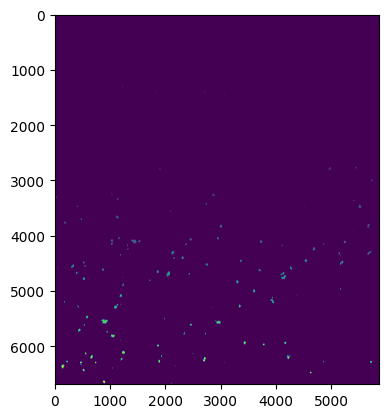

In [46]:
plt.imshow(imgs['8months-disease-replicate_1'])

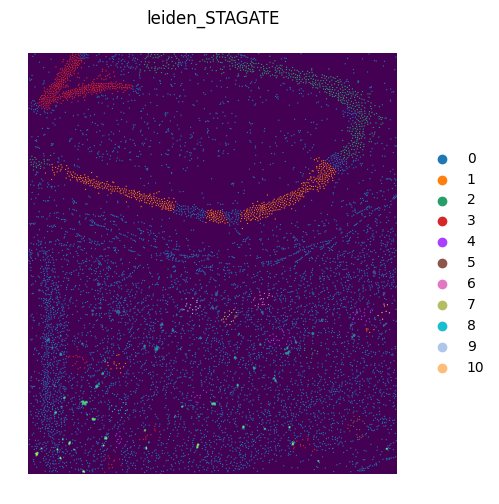

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.spatial(adata, color='leiden_STAGATE', spot_size=20, ncols=1, frameon=False, show=False, ax=ax)
ax.imshow(imgs['8months-disease-replicate_1'])
plt.show()